In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Oversampling

##Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

##Load data

In [ ]:
df = pd.read_csv("/content/Emotion.csv")

In [ ]:
df.head()

ID                                               Data  Love  Joy  \
0   5454.0                             লকাল বাস ভালো এটা থেকে     0    0   
1  22549.0  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0   
2   7033.0  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0   
3  21114.0                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0   
4  23683.0                           সত্যিকার মানুষ তারাই ভাই     0    1   

   Surprise  Anger  Sadness  Fear  Disgust  Hate      Topic    Domain is_admin  
0       0.0      0        1     0      0.0     0     Travel   Youtube    False  
1       0.0      0        1     0      0.0     0   Politics   Youtube    False  
2       0.0      1        0     0      0.0     0   Personal  Facebook    False  
3       0.0      0        1     0      0.0     0  Education  Facebook    False  
4       0.0      0        0     0      0.0     0   Personal   Youtube    False

In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

Data  Love  Joy  Surprise  \
0                             লকাল বাস ভালো এটা থেকে     0    0       0.0   
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0       0.0   
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0       0.0   
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0       0.0   
4                           সত্যিকার মানুষ তারাই ভাই     0    1       0.0   

   Anger  Sadness  Fear  Disgust  Hate  
0      0        1     0      0.0     0  
1      0        1     0      0.0     0  
2      1        0     0      0.0     0  
3      0        1     0      0.0     0  
4      0        0     0      0.0     0

## Count class

In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068




##Removing Rows which has mulitiple 1

In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

Data  Love  Joy  Surprise  \
0                             লকাল বাস ভালো এটা থেকে     0    0       0.0   
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0       0.0   
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0       0.0   
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0       0.0   
4                           সত্যিকার মানুষ তারাই ভাই     0    1       0.0   

   Anger  Sadness  Fear  Disgust  Hate    label  
0      0        1     0      0.0     0  Sadness  
1      0        1     0      0.0     0  Sadness  
2      1        0     0      0.0     0    Anger  
3      0        1     0      0.0     0  Sadness  
4      0        0     0      0.0     0      Joy

In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


## **Remove Unnecessary column**

In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy

In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

##Preprocessing

*1*. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Data'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Data']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 39880
Max sequence length: 250


##Oversample the dataset

In [ ]:
texts = df.drop('label', axis=1)
labels = df['label']
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(texts, labels)
print('Before sampling: ', Counter(labels))
print('After sampling: ', Counter(y_resampled))

Before sampling:  Counter({'Joy': 7669, 'Sadness': 4856, 'Anger': 3435, 'Love': 2279, 'Disgust': 2068, 'Hate': 1591, 'Surprise': 744, 'Fear': 233})
After sampling:  Counter({'Sadness': 7669, 'Anger': 7669, 'Joy': 7669, 'Love': 7669, 'Surprise': 7669, 'Fear': 7669, 'Disgust': 7669, 'Hate': 7669})


##Keras Embedding

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resampled['Data'])
sequences = tokenizer.texts_to_sequences(X_resampled['Data'])
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
y = LabelEncoder().fit_transform(y_resampled)

##Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49081, 250) (12271, 250) (49081,) (12271,)


##ANN

**bold text**### ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

# Assuming you have defined vocab_size, embedding_dim, and max_sequence_length
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())  # Flatten the embedded vectors
model.add(Dense(64, activation='relu'))  # Add a dense layer with 64 units and ReLU activation
model.add(Dense(32, activation='relu'))  # Add another dense layer with 32 units and ReLU activation
model.add(Dense(8, activation='softmax'))  # Output layer with 8 units and softmax activation


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5104640   
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 64)                2048064   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 7155048 (27.29 MB)
Trainable params: 7155048 (27.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
764/767 [============================>.] - ETA: 0s - loss: 1.0042 - accuracy: 0.6244
Epoch 1: val_accuracy improved from -inf to 0.84133, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5
767/767 [==============================] - 39s 48ms/step - loss: 1.0019 - accuracy: 0.6254 - val_loss: 0.4647 - val_accuracy: 0.8413
Epoch 2/50
  1/767 [..............................] - ETA: 6s - loss: 0.3671 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


764/767 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9332
Epoch 2: val_accuracy improved from 0.84133 to 0.90253, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5
767/767 [==============================] - 8s 11ms/step - loss: 0.2033 - accuracy: 0.9334 - val_loss: 0.3159 - val_accuracy: 0.9025
Epoch 3/50
766/767 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9854
Epoch 3: val_accuracy improved from 0.90253 to 0.91068, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5
767/767 [==============================] - 6s 8ms/step - loss: 0.0521 - accuracy: 0.9855 - val_loss: 0.3470 - val_accuracy: 0.9107
Epoch 4/50
760/767 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9936
Epoch 4: val_accuracy did not improve from 0.91068
767/767 [==============================] - 6s 8ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.3782 - val_accuracy: 0.9097
Epoch 5/50
763/767 [==

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.8986
Precision: 0.8960
Recall: 0.8986
F1-Score: 0.8954


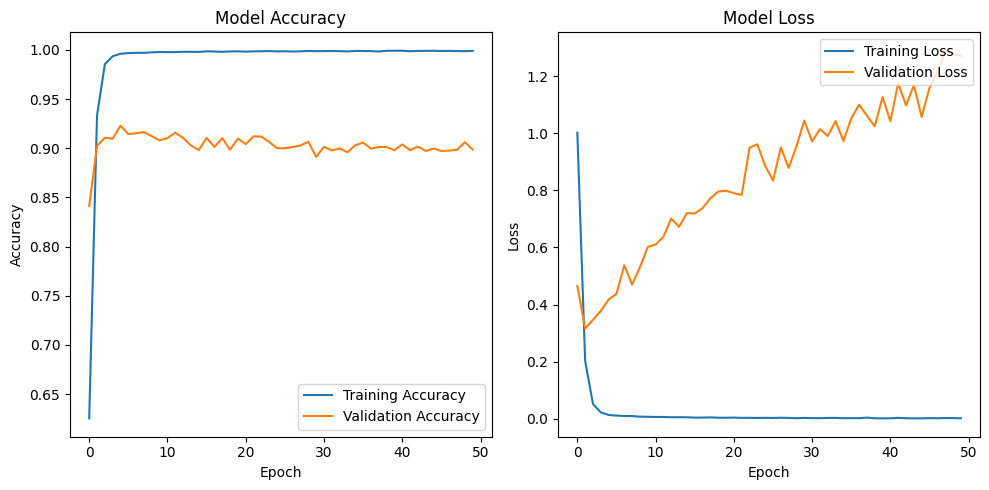

Classification Report:
              precision    recall  f1-score   support

       Angry       0.85      0.86      0.85      1510
     Disgust       0.92      0.96      0.94      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.98      1.00      0.99      1527
         Joy       0.79      0.62      0.70      1541
        Love       0.83      0.94      0.88      1560
     Sadness       0.85      0.81      0.83      1514
    Surprise       0.95      1.00      0.97      1557

    accuracy                           0.90     12271
   macro avg       0.90      0.90      0.90     12271
weighted avg       0.90      0.90      0.90     12271



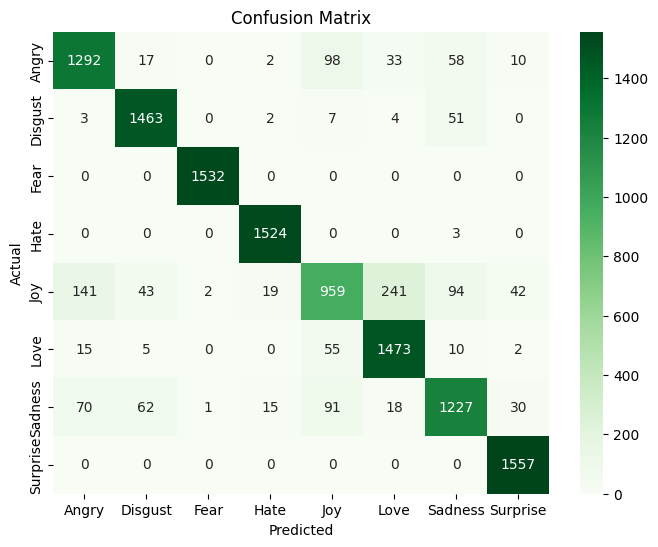

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 3ms/step


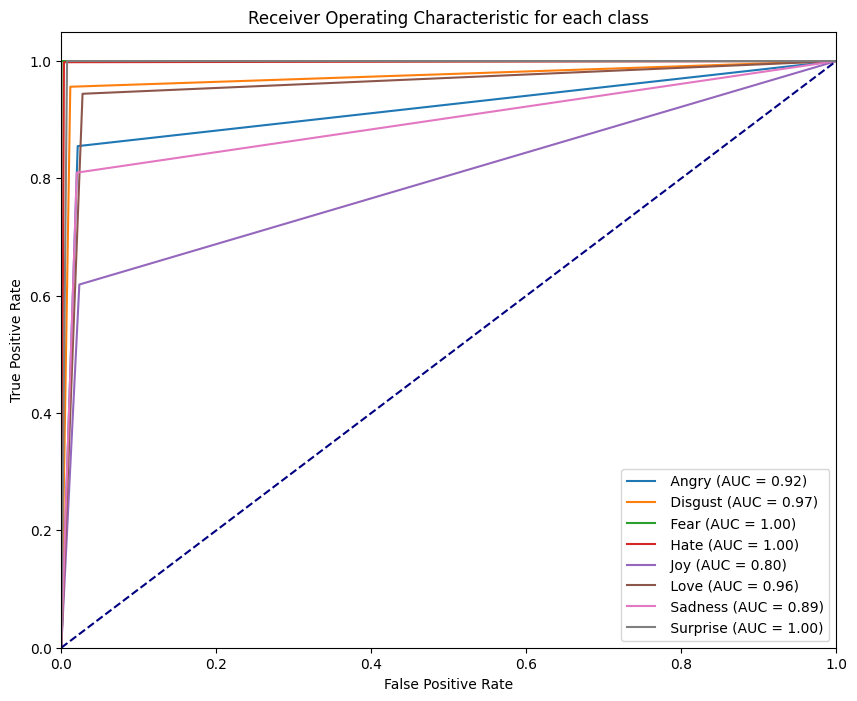

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 2ms/step


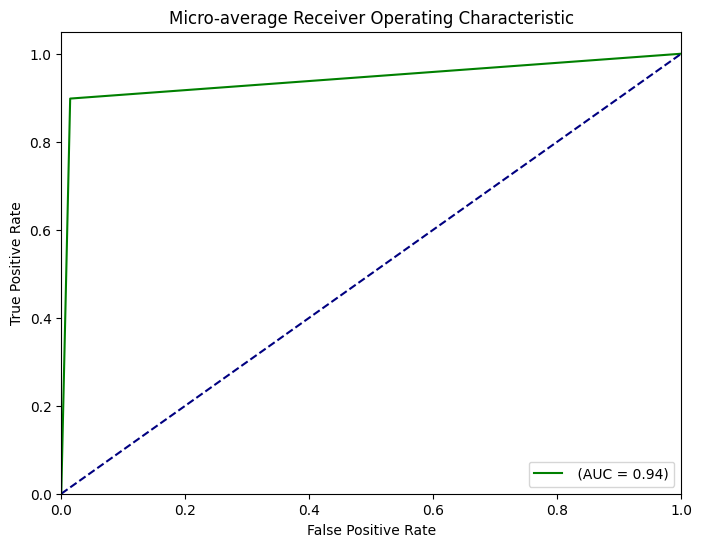

AUC =  0.9418547795615679


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.9230
Precision: 0.9240
Recall: 0.9230
F1-Score: 0.9232


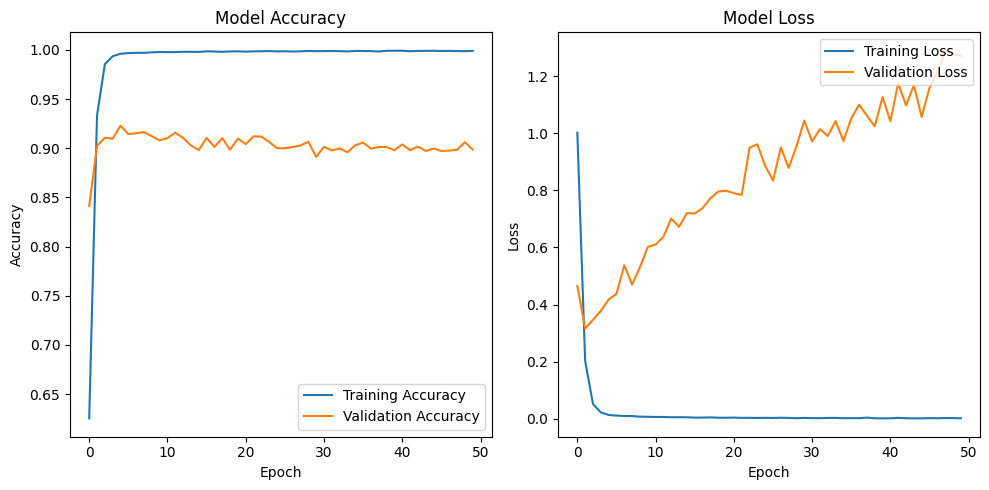

Classification Report:
              precision    recall  f1-score   support

       Angry       0.91      0.85      0.88      1510
     Disgust       0.97      0.95      0.96      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.99      1.00      0.99      1527
         Joy       0.78      0.79      0.78      1541
        Love       0.94      0.91      0.93      1560
     Sadness       0.82      0.88      0.85      1514
    Surprise       0.98      1.00      0.99      1557

    accuracy                           0.92     12271
   macro avg       0.92      0.92      0.92     12271
weighted avg       0.92      0.92      0.92     12271



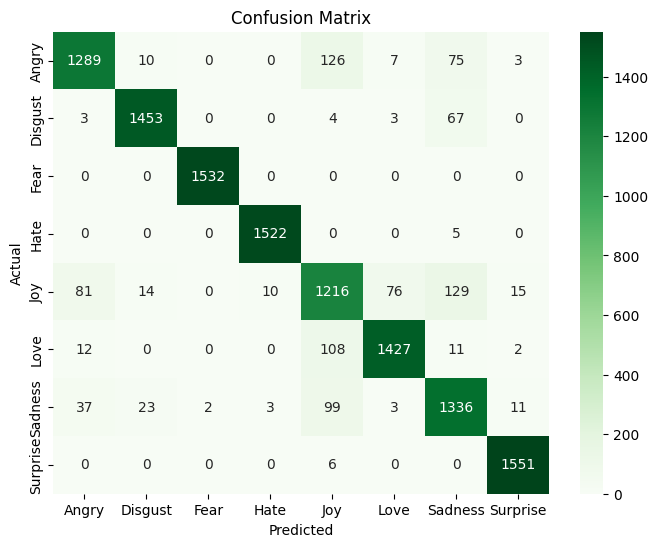

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 2ms/step


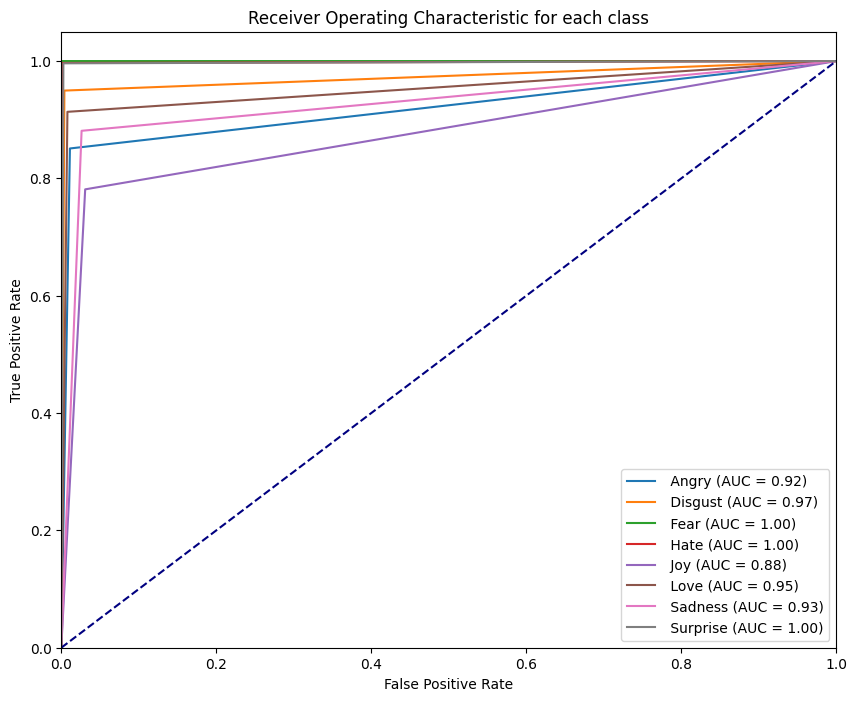

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 3ms/step


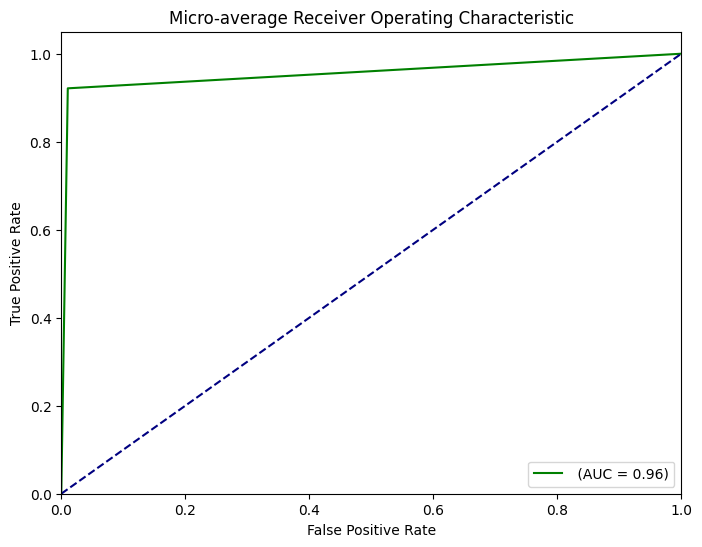

AUC =  0.9554233558797164


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Using L2

### ANN using l2

In [ ]:
from tensorflow.keras import regularizers

# Assuming you have defined vocab_size, embedding_dim, and max_sequence_length
embedding_dim = 128
l2_regularizer = regularizers.l2(0.01)  # Define L2 regularization with a regularization strength of 0.01

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())  # Flatten the embedded vectors
model.add(Dense(64, activation='relu', kernel_regularizer=l2_regularizer))  # Add a dense layer with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2_regularizer))  # Add another dense layer with L2 regularization
model.add(Dense(8, activation='softmax'))  # Output layer with 8 units and softmax activation


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2048064   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 7155048 (27.29 MB)
Trainable params: 7155048 (27.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
758/767 [============================>.] - ETA: 0s - loss: 1.5950 - accuracy: 0.4820
Epoch 1: val_accuracy improved from -inf to 0.70964, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5
767/767 [==============================] - 43s 54ms/step - loss: 1.5890 - accuracy: 0.4844 - val_loss: 1.0005 - val_accuracy: 0.7096
Epoch 2/50
  1/767 [..............................] - ETA: 7s - loss: 0.9668 - accuracy: 0.7344

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


766/767 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.8235
Epoch 2: val_accuracy improved from 0.70964 to 0.81200, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5
767/767 [==============================] - 13s 17ms/step - loss: 0.7636 - accuracy: 0.8235 - val_loss: 0.7482 - val_accuracy: 0.8120
Epoch 3/50
767/767 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.9236
Epoch 3: val_accuracy improved from 0.81200 to 0.86986, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5
767/767 [==============================] - 13s 17ms/step - loss: 0.4887 - accuracy: 0.9236 - val_loss: 0.6028 - val_accuracy: 0.8699
Epoch 4/50
766/767 [============================>.] - ETA: 0s - loss: 0.3583 - accuracy: 0.9589
Epoch 4: val_accuracy improved from 0.86986 to 0.87246, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5
767/767 [==============================] - 12s 15ms/step - loss:

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.8930
Precision: 0.8909
Recall: 0.8930
F1-Score: 0.8909


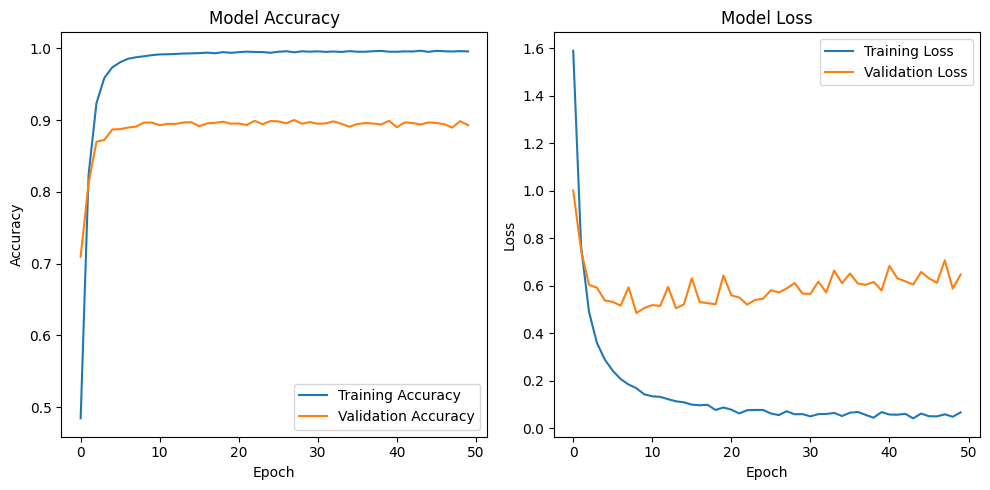

Classification Report:
              precision    recall  f1-score   support

       Angry       0.89      0.82      0.85      1510
     Disgust       0.97      0.95      0.96      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.99      0.99      0.99      1527
         Joy       0.71      0.62      0.66      1541
        Love       0.84      0.95      0.89      1560
     Sadness       0.80      0.81      0.80      1514
    Surprise       0.95      1.00      0.97      1557

    accuracy                           0.89     12271
   macro avg       0.89      0.89      0.89     12271
weighted avg       0.89      0.89      0.89     12271



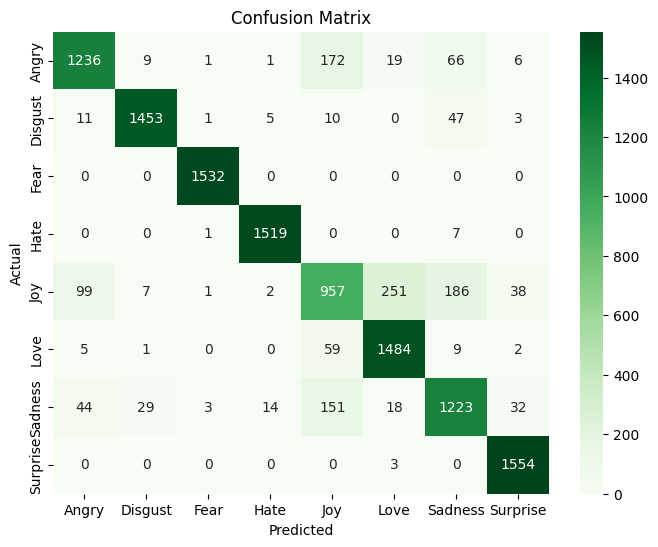

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 1ms/step


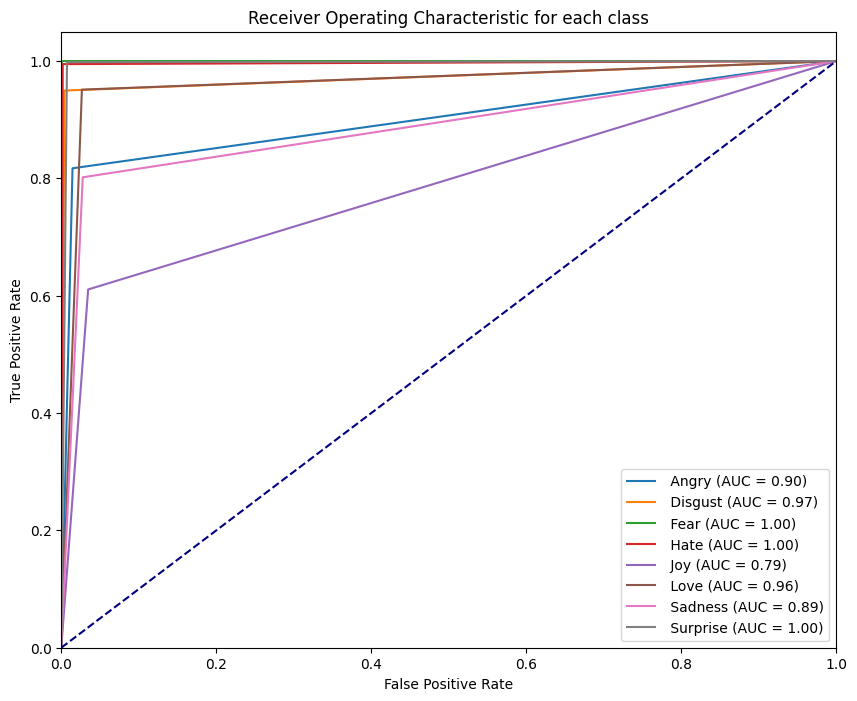

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 2ms/step


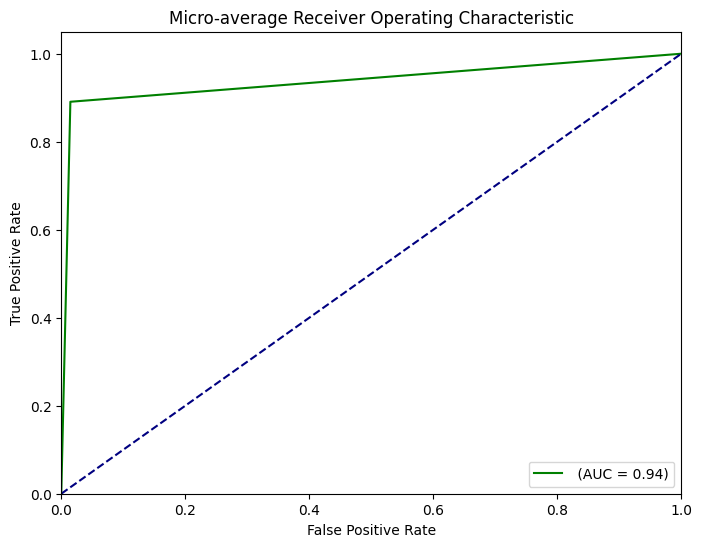

AUC =  0.9380653573465895


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.9002
Precision: 0.8985
Recall: 0.9002
F1-Score: 0.8991


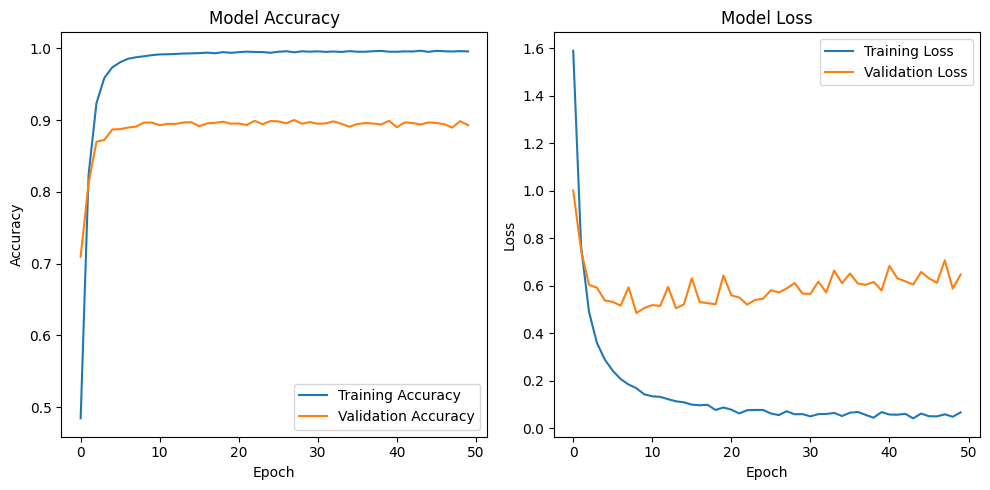

Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.83      0.85      1510
     Disgust       0.96      0.95      0.96      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.98      0.99      0.99      1527
         Joy       0.72      0.68      0.70      1541
        Love       0.89      0.94      0.91      1560
     Sadness       0.81      0.81      0.81      1514
    Surprise       0.96      1.00      0.98      1557

    accuracy                           0.90     12271
   macro avg       0.90      0.90      0.90     12271
weighted avg       0.90      0.90      0.90     12271



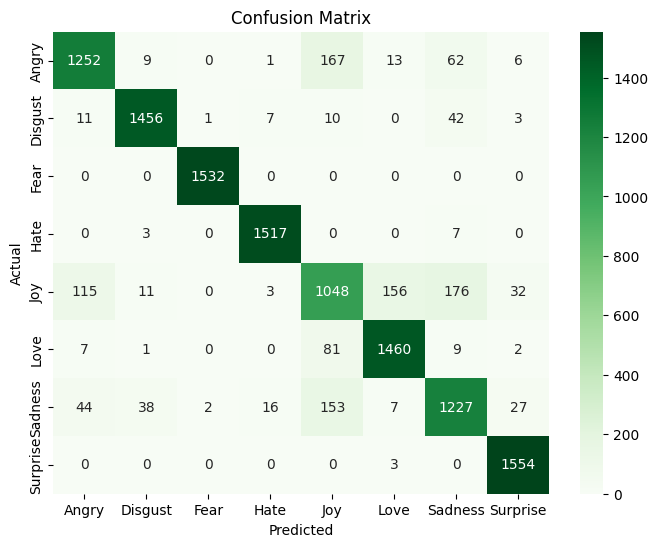

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/ANN/best_model_new2_l2.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 2ms/step


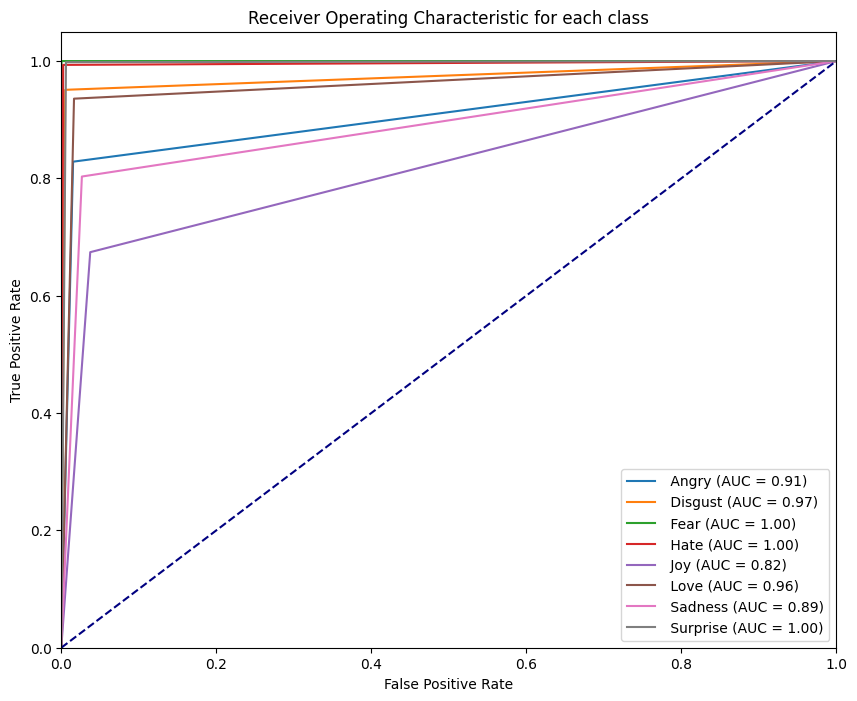

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 2ms/step


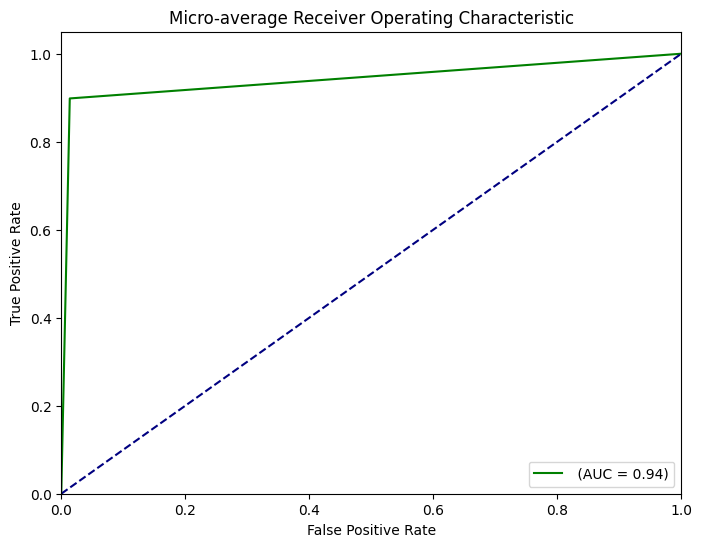

AUC =  0.9423437372667265


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


## CNN

### CNN

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5104640   
                                                                 
 conv1d (Conv1D)             (None, 248, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 124, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense (Dense)               (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 0.9724 - accuracy: 0.6425
Epoch 1: val_accuracy improved from -inf to 0.83384, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 70s 83ms/step - loss: 0.9724 - accuracy: 0.6425 - val_loss: 0.4577 - val_accuracy: 0.8338
Epoch 2/50
762/767 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9227
Epoch 2: val_accuracy improved from 0.83384 to 0.90547, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5
767/767 [==============================] - 10s 13ms/step - loss: 0.2339 - accuracy: 0.9230 - val_loss: 0.3087 - val_accuracy: 0.9055
Epoch 3/50
765/767 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9777
Epoch 3: val_accuracy improved from 0.90547 to 0.91826, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5
767/767 [==============================] - 7s 9ms/step - loss: 0.0752 - accuracy: 0.9777 - val_loss: 0.3161 - val_accuracy: 0.9183
Epoch 4/50
763/767 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9900
Epoch 4: val_accuracy did not improve from 0.91826
767/767 [=

384/384 [==============================] - 1s 3ms/step
Accuracy: 0.9085
Precision: 0.9059
Recall: 0.9085
F1-Score: 0.9061


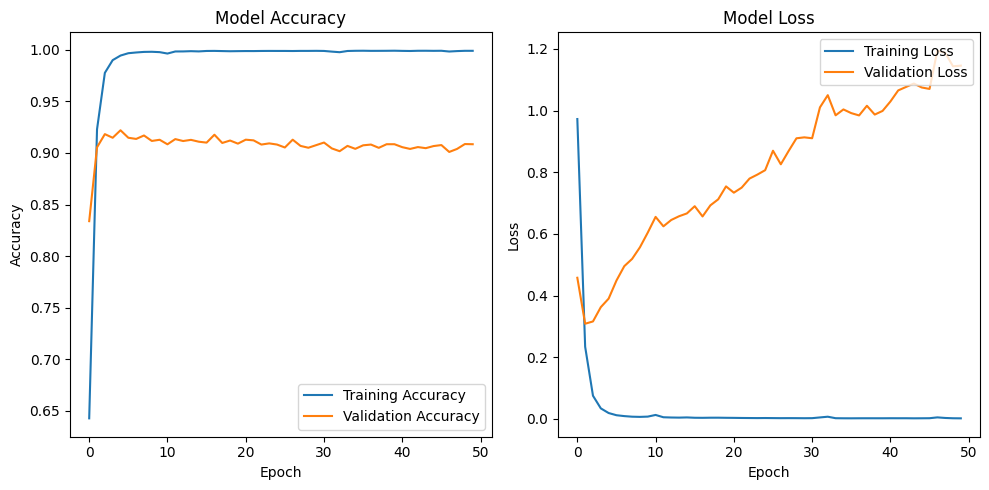

Classification Report:
              precision    recall  f1-score   support

       Angry       0.85      0.87      0.86      1510
     Disgust       0.94      0.96      0.95      1530
        Fear       0.99      1.00      1.00      1532
        Hate       0.97      1.00      0.99      1527
         Joy       0.79      0.67      0.72      1541
        Love       0.87      0.95      0.91      1560
     Sadness       0.87      0.82      0.85      1514
    Surprise       0.96      1.00      0.98      1557

    accuracy                           0.91     12271
   macro avg       0.91      0.91      0.91     12271
weighted avg       0.91      0.91      0.91     12271



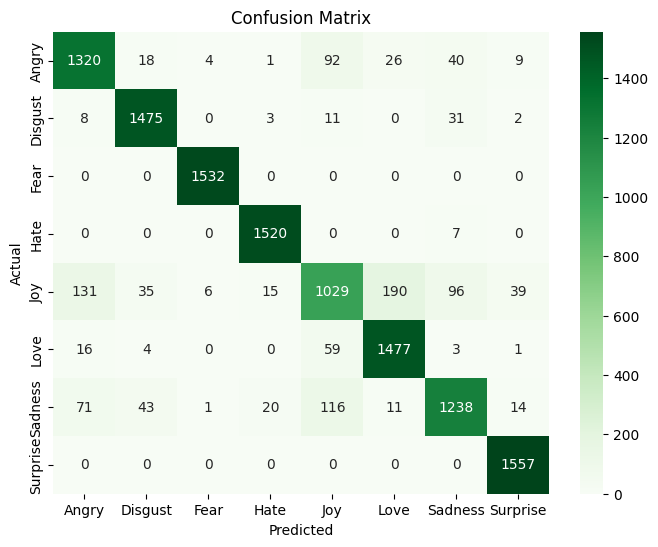

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 3ms/step


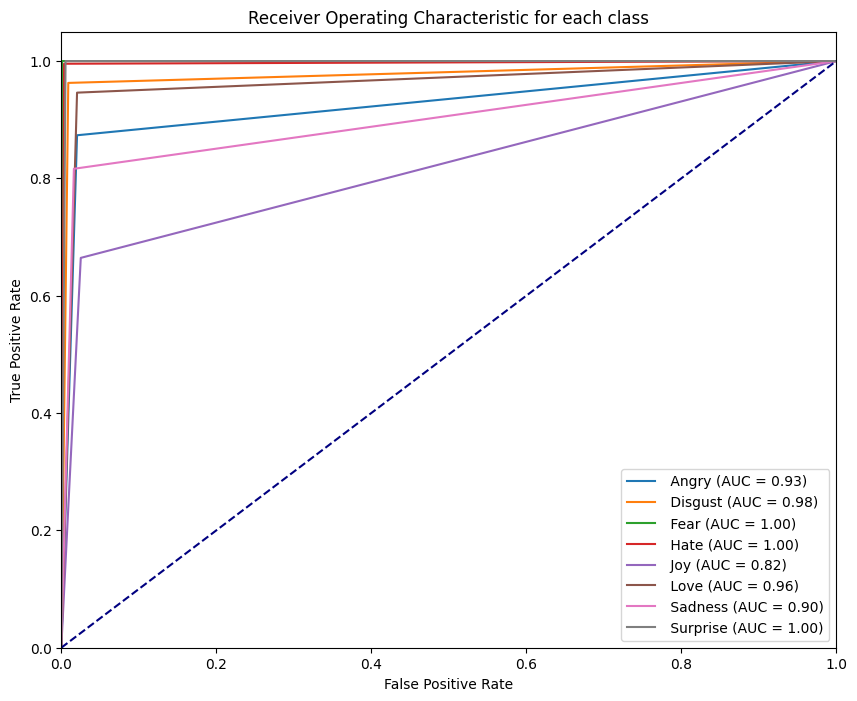

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 3ms/step


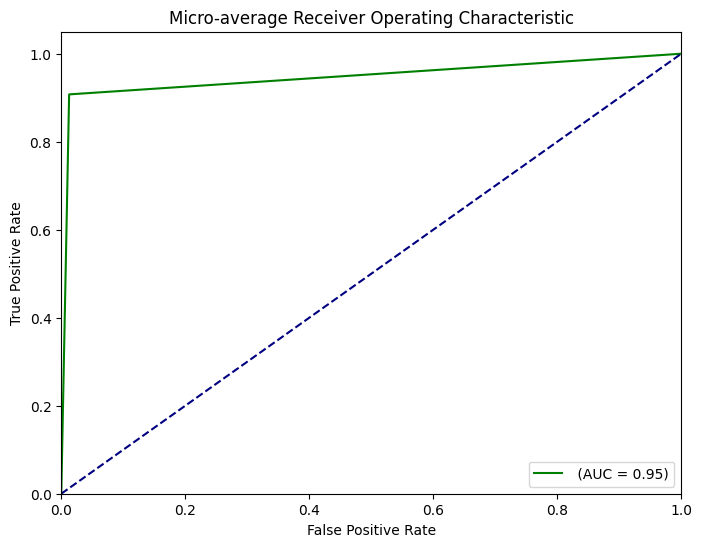

AUC =  0.9474603303957065


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Best model

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.9220
Precision: 0.9216
Recall: 0.9220
F1-Score: 0.9214


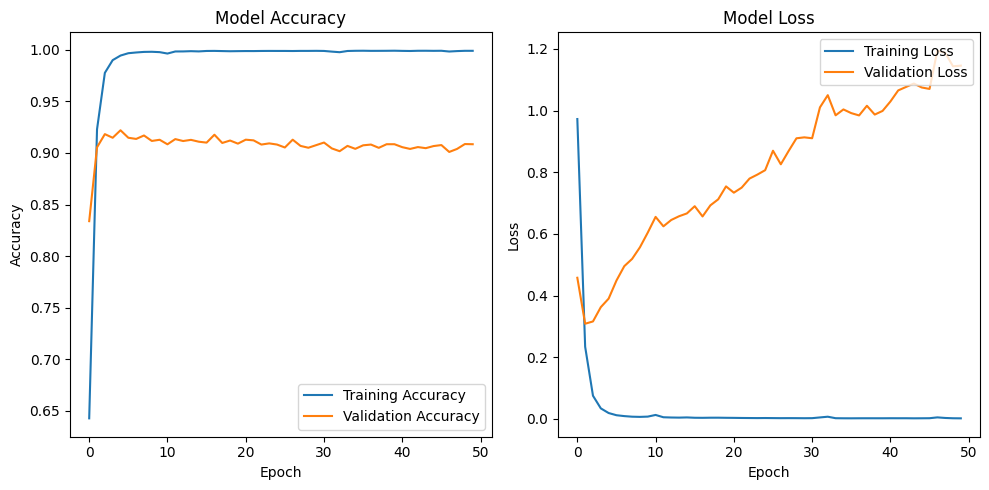

Classification Report:
              precision    recall  f1-score   support

       Angry       0.86      0.88      0.87      1510
     Disgust       0.94      0.96      0.95      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.98      1.00      0.99      1527
         Joy       0.79      0.78      0.78      1541
        Love       0.93      0.93      0.93      1560
     Sadness       0.91      0.82      0.86      1514
    Surprise       0.97      1.00      0.98      1557

    accuracy                           0.92     12271
   macro avg       0.92      0.92      0.92     12271
weighted avg       0.92      0.92      0.92     12271



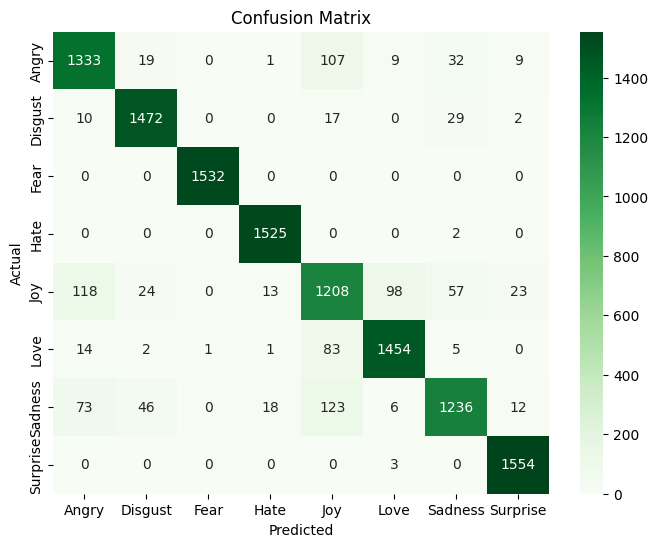

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 4ms/step


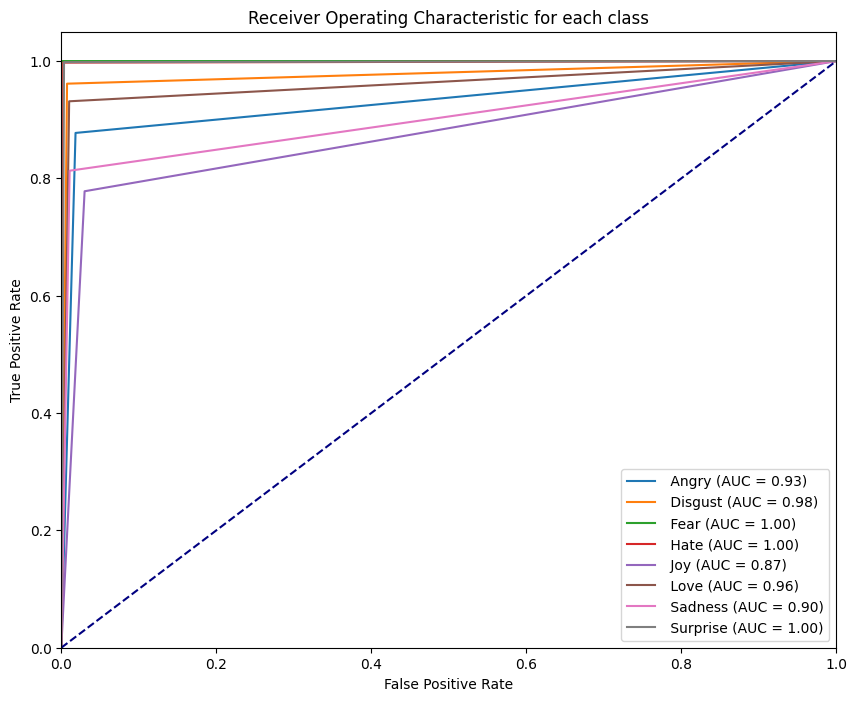

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 3ms/step


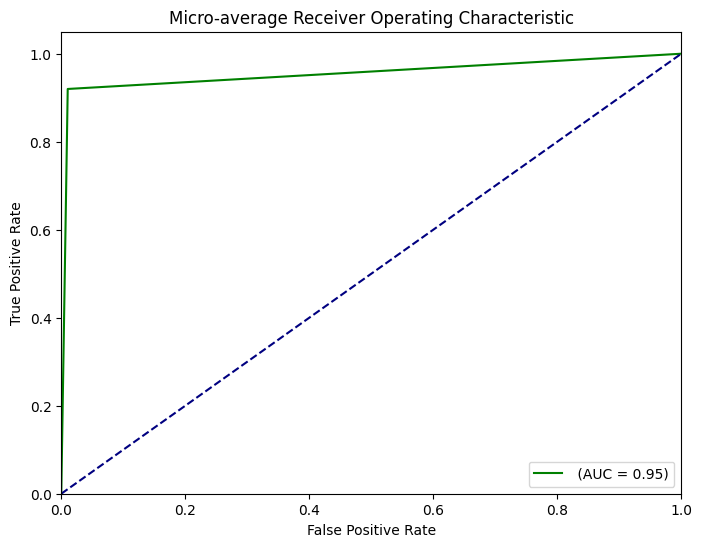

AUC =  0.9547481285725928


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Using L2

### CNN using l2

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
764/767 [============================>.] - ETA: 0s - loss: 1.6667 - accuracy: 0.4471
Epoch 1: val_accuracy improved from -inf to 0.63157, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 71s 88ms/step - loss: 1.6654 - accuracy: 0.4477 - val_loss: 1.2930 - val_accuracy: 0.6316
Epoch 2/50
765/767 [============================>.] - ETA: 0s - loss: 1.0954 - accuracy: 0.7299
Epoch 2: val_accuracy improved from 0.63157 to 0.75031, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
767/767 [==============================] - 16s 21ms/step - loss: 1.0950 - accuracy: 0.7302 - val_loss: 1.0533 - val_accuracy: 0.7503
Epoch 3/50
762/767 [============================>.] - ETA: 0s - loss: 0.8808 - accuracy: 0.8285
Epoch 3: val_accuracy improved from 0.75031 to 0.79684, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
767/767 [==============================] - 13s 17ms/step - loss: 0.8804 - accuracy: 0.8285 - val_loss: 0.9404 - val_accuracy: 0.7968
Epoch 4/50
763/767 [============================>.] - ETA: 0s - loss: 0.7548 - accuracy: 0.8763
Epoch 4: val_accuracy improved from 0.79684 to 0.81917, s

384/384 [==============================] - 1s 2ms/step
Accuracy: 0.8858
Precision: 0.8840
Recall: 0.8858
F1-Score: 0.8804


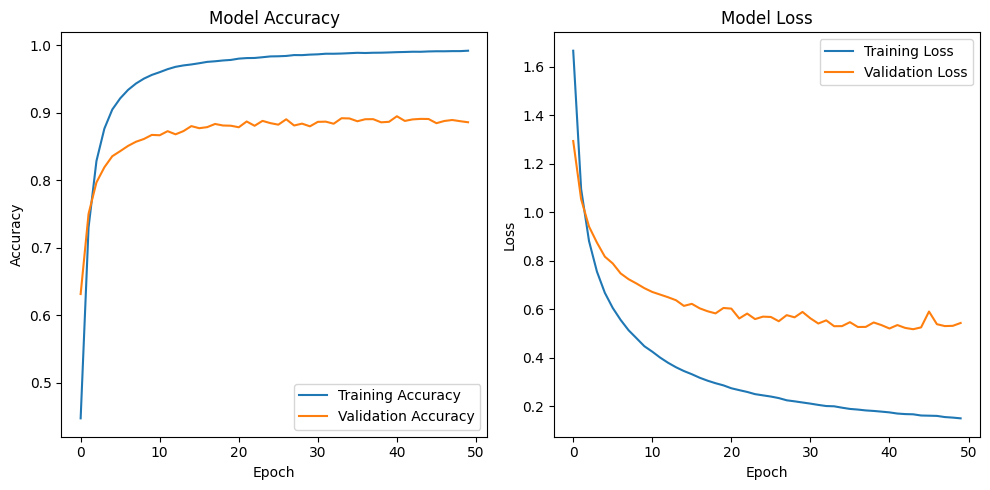

Classification Report:
              precision    recall  f1-score   support

       Angry       0.84      0.85      0.84      1510
     Disgust       0.89      0.96      0.92      1530
        Fear       0.99      1.00      0.99      1532
        Hate       0.96      0.99      0.98      1527
         Joy       0.81      0.55      0.65      1541
        Love       0.79      0.94      0.86      1560
     Sadness       0.86      0.80      0.83      1514
    Surprise       0.92      1.00      0.96      1557

    accuracy                           0.89     12271
   macro avg       0.88      0.89      0.88     12271
weighted avg       0.88      0.89      0.88     12271



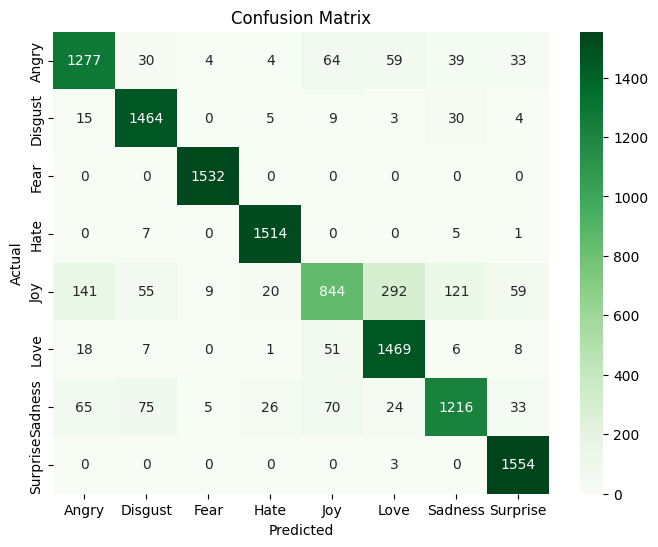

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 2ms/step


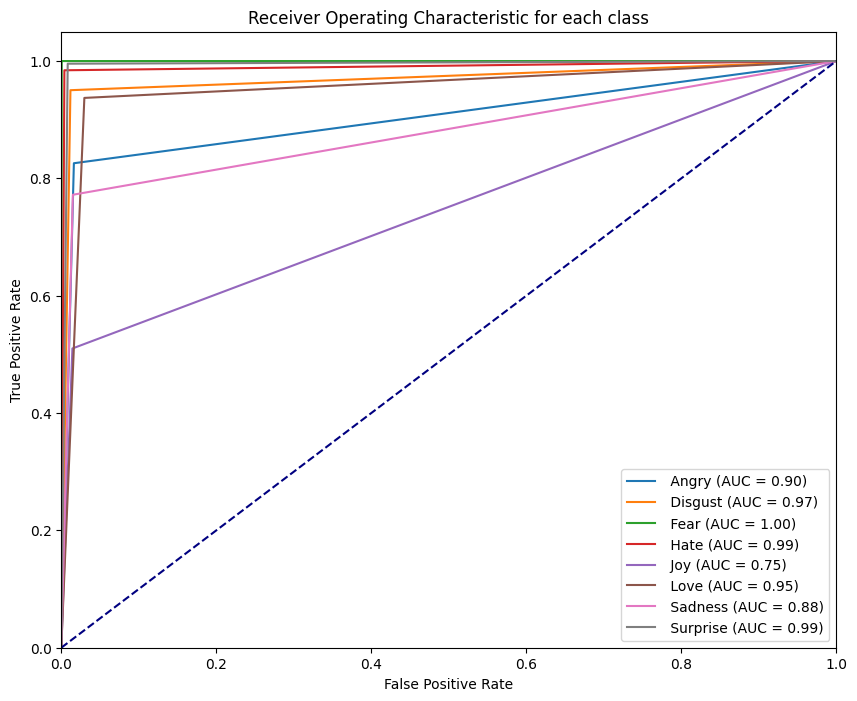

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 2s 4ms/step


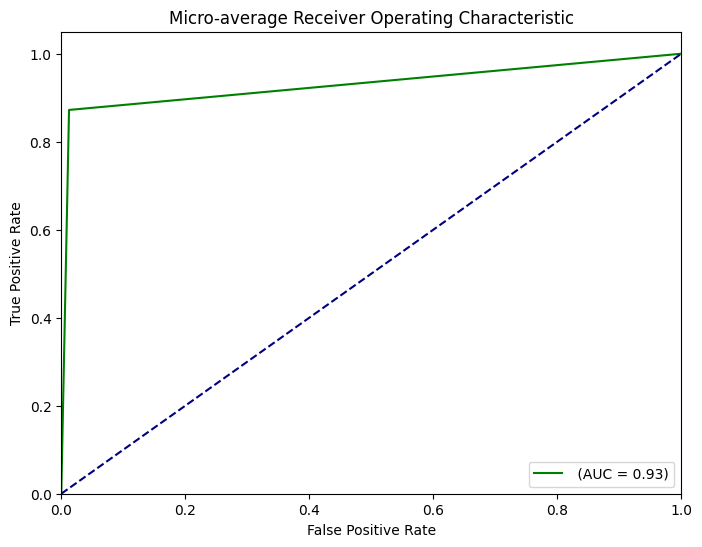

AUC =  0.9298578530100005


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

384/384 [==============================] - 1s 3ms/step
Accuracy: 0.8947
Precision: 0.8921
Recall: 0.8947
F1-Score: 0.8919


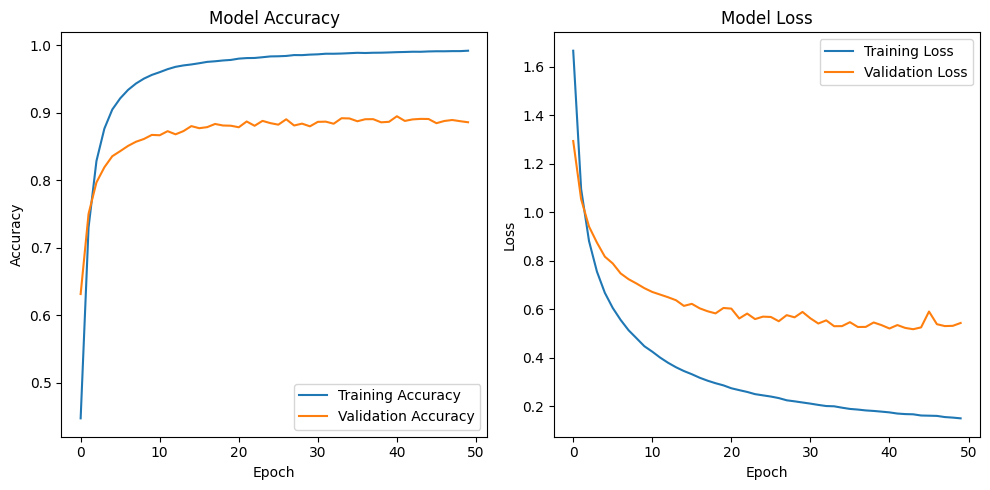

Classification Report:
              precision    recall  f1-score   support

       Angry       0.89      0.84      0.86      1510
     Disgust       0.90      0.96      0.92      1530
        Fear       0.99      1.00      1.00      1532
        Hate       0.96      0.99      0.98      1527
         Joy       0.78      0.65      0.71      1541
        Love       0.83      0.92      0.88      1560
     Sadness       0.85      0.81      0.83      1514
    Surprise       0.94      0.99      0.96      1557

    accuracy                           0.89     12271
   macro avg       0.89      0.89      0.89     12271
weighted avg       0.89      0.89      0.89     12271



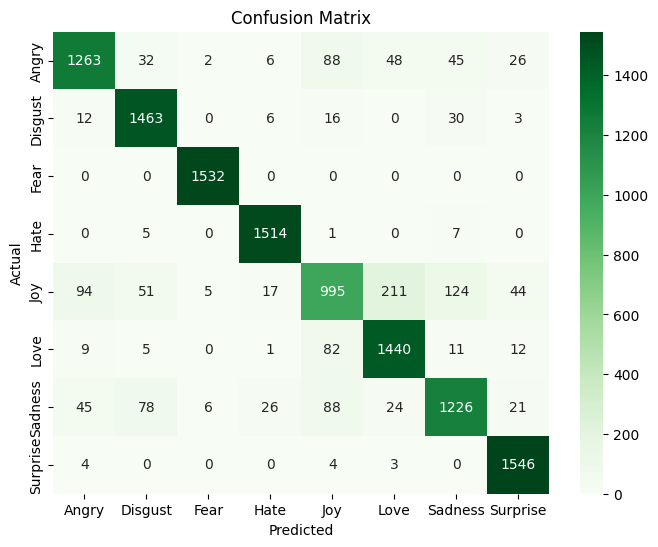

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 1s 3ms/step


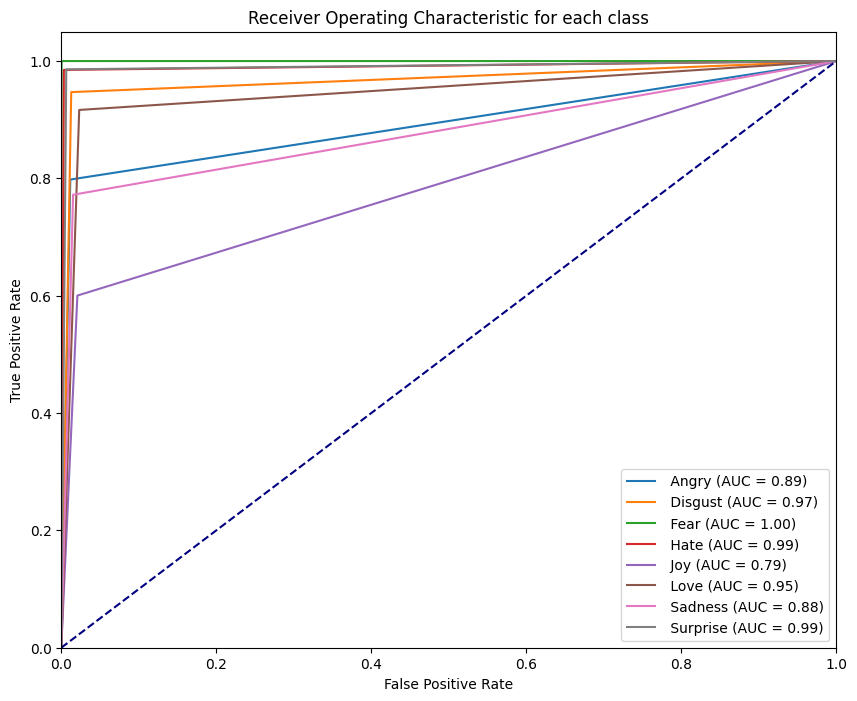

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 1s 3ms/step


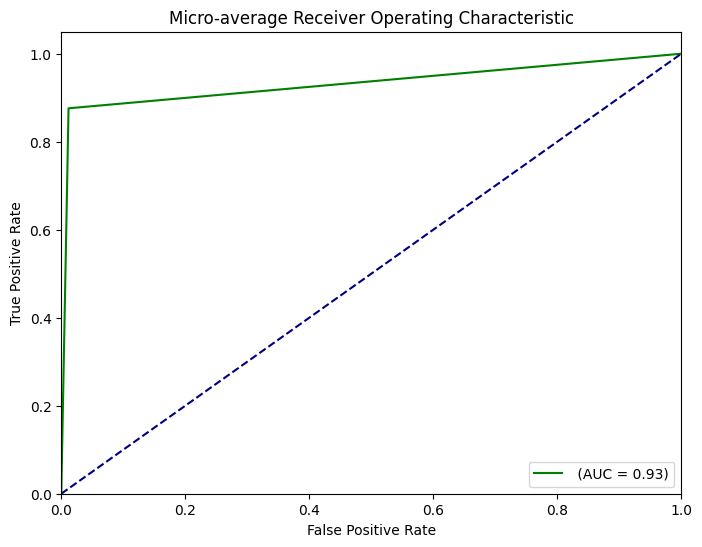

AUC =  0.9321221928588891


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


##BiLstm

### **Bi-LSTM 90**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define parameters
embedding_dim = 128

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Flatten())  # Flatten layer
model.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Print model summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 bidirectional_5 (Bidirecti  (None, 250, 128)          98816     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense_5 (Dense)             (None, 8)                 256008    
                                                                 
Total params: 5459464 (20.83 MB)
Trainable params: 5459464 (20.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
766/767 [============================>.] - ETA: 0s - loss: 0.8316 - accuracy: 0.6886
Epoch 1: val_accuracy improved from -inf to 0.84875, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 46s 52ms/step - loss: 0.8312 - accuracy: 0.6888 - val_loss: 0.4321 - val_accuracy: 0.8487
Epoch 2/50
765/767 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9285
Epoch 2: val_accuracy improved from 0.84875 to 0.89879, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1.h5
767/767 [==============================] - 23s 29ms/step - loss: 0.2122 - accuracy: 0.9284 - val_loss: 0.3253 - val_accuracy: 0.8988
Epoch 3/50
767/767 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9711
Epoch 3: val_accuracy improved from 0.89879 to 0.90604, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1.h5
767/767 [==============================] - 20s 27ms/step - loss: 0.0869 - accuracy: 0.9711 - val_loss: 0.3866 - val_accuracy: 0.9060
Epoch 4/50
767/767 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9821
Epoch 4: val_accuracy improved from 0.90604 to 0.90

384/384 [==============================] - 4s 11ms/step
Accuracy: 0.9038
Precision: 0.9016
Recall: 0.9038
F1-Score: 0.9005


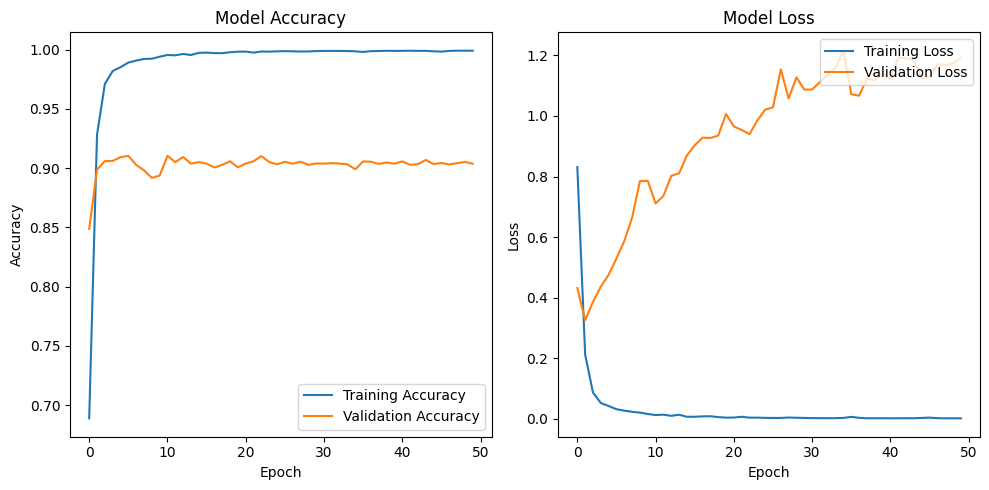

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1510
           1       0.91      0.97      0.94      1530
           2       0.99      1.00      1.00      1532
           3       0.98      1.00      0.99      1527
           4       0.81      0.64      0.71      1541
           5       0.85      0.94      0.90      1560
           6       0.90      0.80      0.85      1514
           7       0.94      1.00      0.97      1557

    accuracy                           0.90     12271
   macro avg       0.90      0.90      0.90     12271
weighted avg       0.90      0.90      0.90     12271



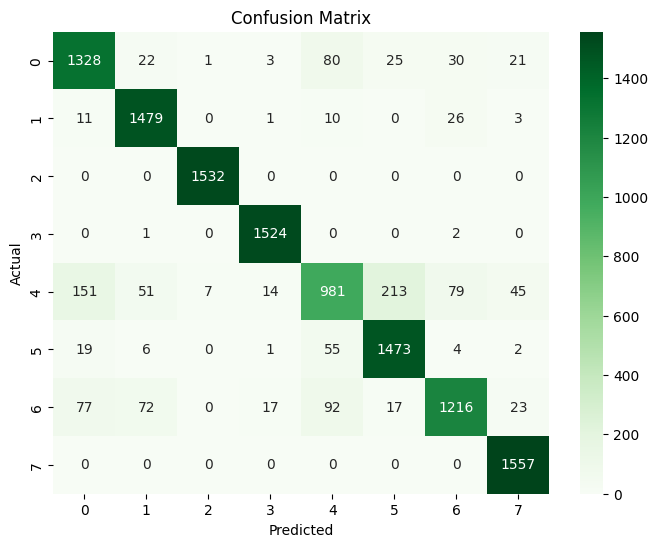

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

# Assuming label_encoder was used to encode your labels
label_encoder = LabelEncoder()

# Fit the LabelEncoder with training labels
label_encoder.fit(y_train)

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Inverse transform encoded labels to actual labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_pred)

# Accuracy
accuracy = accuracy_score(y_test_actual, y_pred_actual)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
print(f'F1-Score: {f1:.4f}')

# Learning Curve
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_pred_actual))

# Confusion Matrix
cm = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

# Add labels to the confusion matrix
tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

384/384 [==============================] - 9s 24ms/step


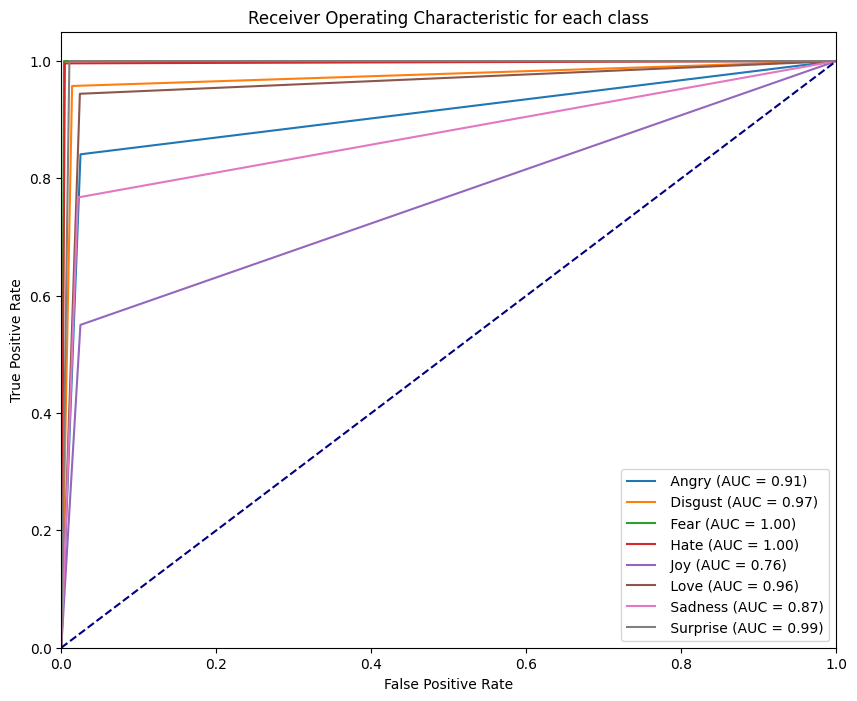

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

384/384 [==============================] - 8s 21ms/step


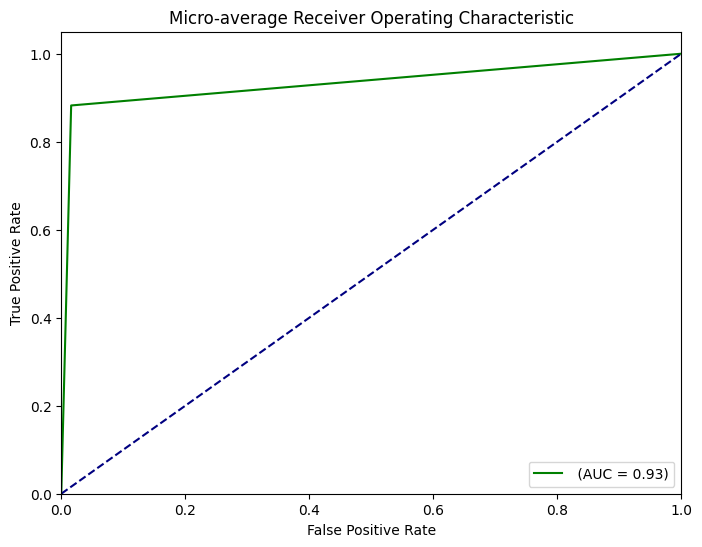

AUC =  0.9332339895456186


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))

###**BiLSTM 90 With L2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2  # Correct import

# Define parameters
embedding_dim = 128

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))  # Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))))  # Bidirectional LSTM layer with L2 regularization
model.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5104640   
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 5303304 (20.23 MB)
Trainable params: 5303304 (20.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 1.7045 - accuracy: 0.4796
Epoch 1: val_accuracy improved from -inf to 0.68919, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 83s 87ms/step - loss: 1.7045 - accuracy: 0.4796 - val_loss: 0.8817 - val_accuracy: 0.6892
Epoch 2/50
767/767 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7893
Epoch 2: val_accuracy improved from 0.68919 to 0.81966, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2.h5
767/767 [==============================] - 38s 50ms/step - loss: 0.6232 - accuracy: 0.7893 - val_loss: 0.5562 - val_accuracy: 0.8197
Epoch 3/50
766/767 [============================>.] - ETA: 0s - loss: 0.3744 - accuracy: 0.8881
Epoch 3: val_accuracy improved from 0.81966 to 0.85282, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2.h5
767/767 [==============================] - 39s 51ms/step - loss: 0.3743 - accuracy: 0.8882 - val_loss: 0.4874 - val_accuracy: 0.8528
Epoch 4/50
767/767 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9276
Epoch 4: val_accuracy improved from 0.85282 to 0.86

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


384/384 [==============================] - 8s 17ms/step
Accuracy: 0.8838
Precision: 0.8785
Recall: 0.8838
F1-Score: 0.8784


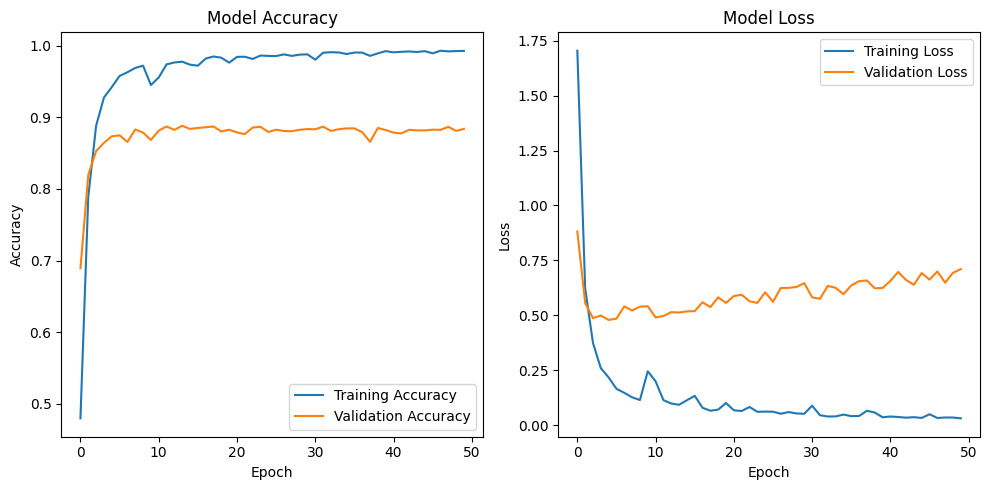

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.84      0.83      1510
     Disgust       0.90      0.96      0.93      1530
        Fear       0.97      1.00      0.99      1532
        Hate       0.97      1.00      0.98      1527
         Joy       0.75      0.56      0.64      1541
        Love       0.85      0.94      0.89      1560
     Sadness       0.83      0.77      0.80      1514
    Surprise       0.93      1.00      0.96      1557

    accuracy                           0.88     12271
   macro avg       0.88      0.88      0.88     12271
weighted avg       0.88      0.88      0.88     12271



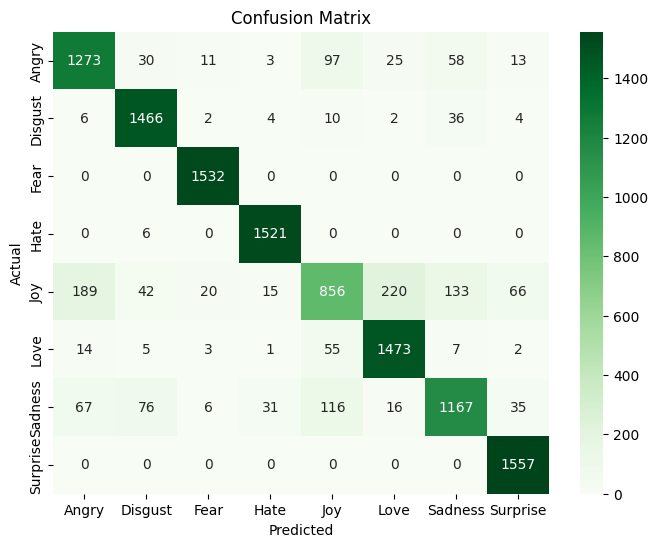

In [ ]:
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 9s 24ms/step


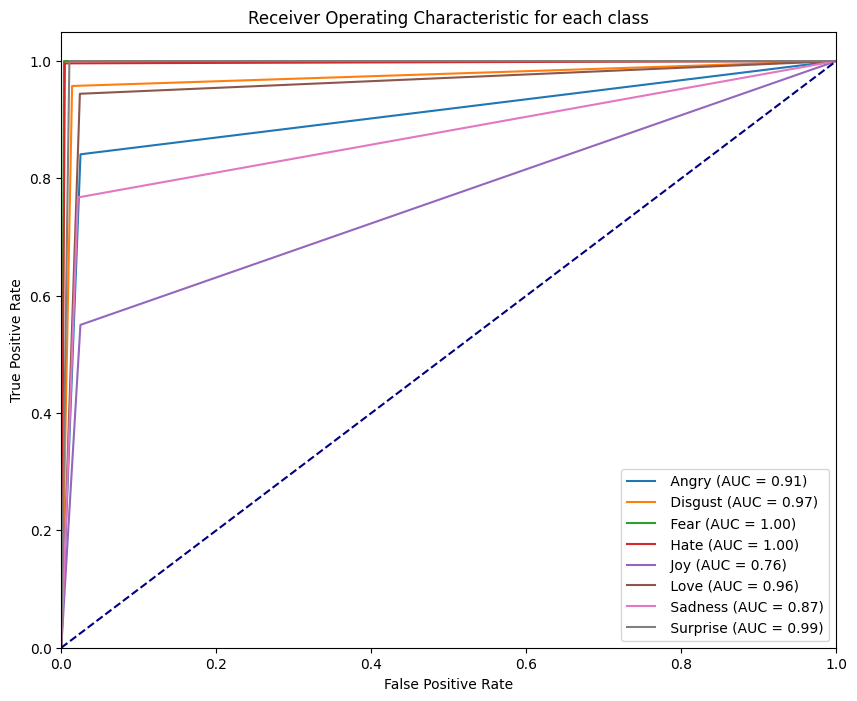

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

384/384 [==============================] - 8s 21ms/step


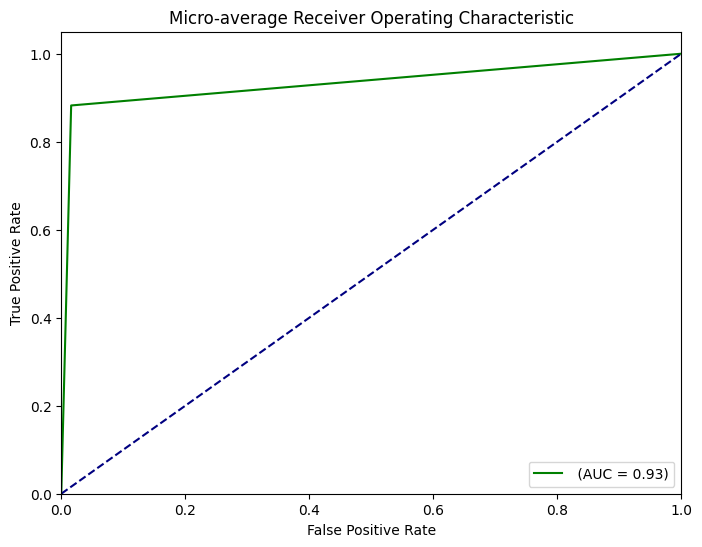

AUC =  0.9332339895456186


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))

In [ ]:
model.save('/content/drive/MyDrive/Model/Opu/BiLSTM/best_model_BiLstm_88acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##LSTM

### **LSTM 88**

In [ ]:
from keras.layers import Layer, LSTM, Dense, Embedding, Input
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))


checkpoint = ModelCheckpoint('/content/drive/MyDrive/LSTM/best_model_lstm_1', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 lstm_1 (LSTM)               (None, 250, 64)           49408     
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_1 (Dense)             (None, 8)                 128008    
                                                                 
Total params: 5282056 (20.15 MB)
Trainable params: 5282056 (20.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 1.8947 - accuracy: 0.2384
Epoch 1: val_accuracy improved from -inf to 0.41692, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm_1
767/767 [==============================] - 68s 82ms/step - loss: 1.8947 - accuracy: 0.2384 - val_loss: 1.4945 - val_accuracy: 0.4169
Epoch 2/50
767/767 [==============================] - ETA: 0s - loss: 1.3154 - accuracy: 0.4924
Epoch 2: val_accuracy improved from 0.41692 to 0.53769, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm_1
767/767 [==============================] - 43s 55ms/step - loss: 1.3154 - accuracy: 0.4924 - val_loss: 1.2190 - val_accuracy: 0.5377
Epoch 3/50
766/767 [============================>.] - ETA: 0s - loss: 1.1937 - accuracy: 0.5513
Epoch 3: val_accuracy did not improve from 0.53769
767/767 [==============================] - 28s 36ms/step - loss: 1.1937 - accuracy: 0.5513 - val_loss: 1.3215 - val_accuracy: 0.4645
Epoch 4/50
766/767 [=

384/384 [==============================] - 2s 5ms/step
Accuracy: 0.8852
Precision: 0.8821
Recall: 0.8852
F1-Score: 0.8827


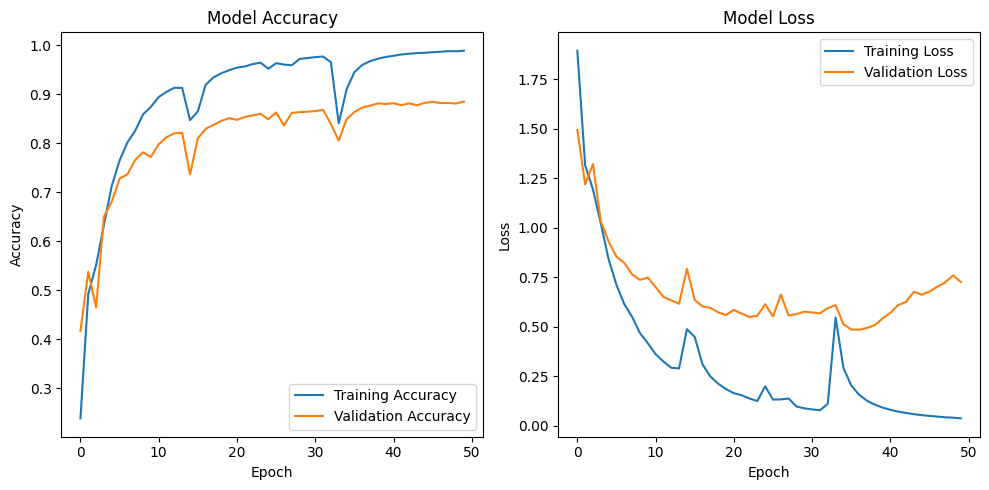

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1510
           1       0.93      0.94      0.93      1530
           2       0.99      1.00      0.99      1532
           3       0.96      0.99      0.98      1527
           4       0.69      0.62      0.66      1541
           5       0.82      0.92      0.87      1560
           6       0.84      0.75      0.79      1514
           7       0.96      0.99      0.98      1557

    accuracy                           0.89     12271
   macro avg       0.88      0.88      0.88     12271
weighted avg       0.88      0.89      0.88     12271



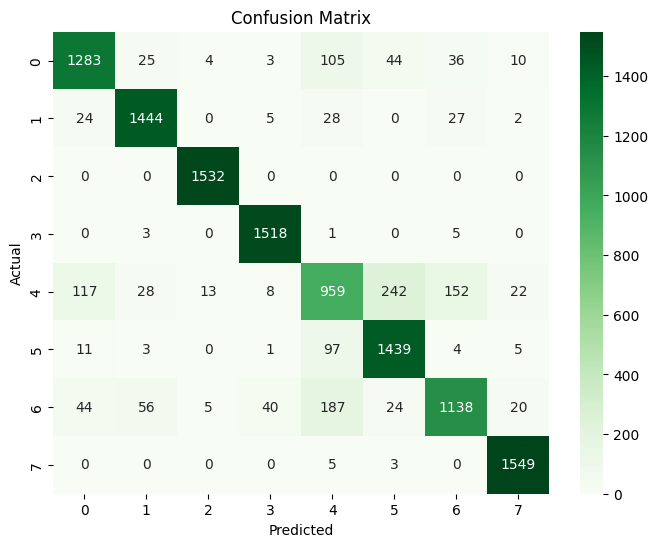

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

# Assuming label_encoder was used to encode your labels
label_encoder = LabelEncoder()

# Fit the LabelEncoder with training labels
label_encoder.fit(y_train)

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Inverse transform encoded labels to actual labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_pred)

# Accuracy
accuracy = accuracy_score(y_test_actual, y_pred_actual)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
print(f'F1-Score: {f1:.4f}')

# Learning Curve
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_pred_actual))

# Confusion Matrix
cm = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

# Add labels to the confusion matrix
tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

384/384 [==============================] - 2s 6ms/step


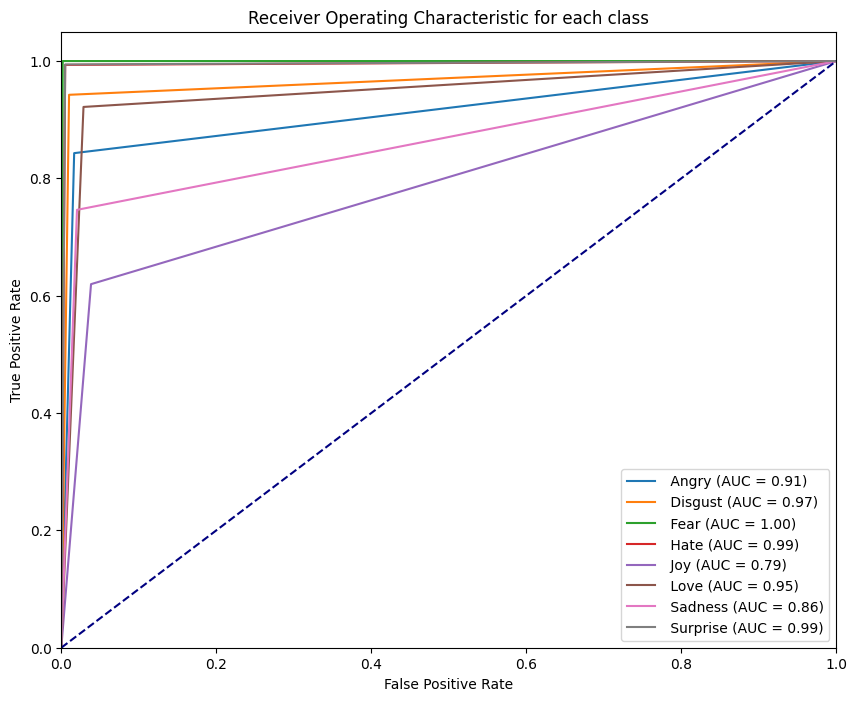

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 2s 5ms/step


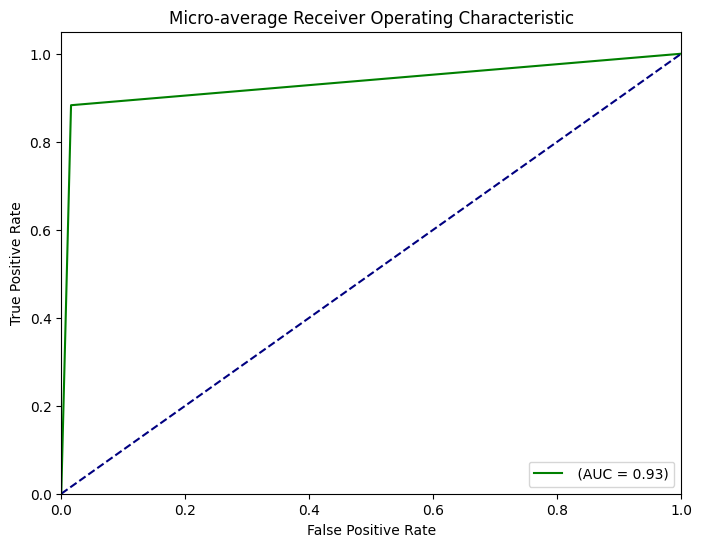

AUC =  0.9336181705996717


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Using L2

###**LSTM 88 With L2**

In [ ]:
from keras.layers import Layer, LSTM, Dense, Embedding, Input
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))


checkpoint = ModelCheckpoint('/content/drive/MyDrive/opu/LSTM/best_model_lstm_2', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 lstm_2 (LSTM)               (None, 250, 64)           49408     
                                                                 
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 8)                 128008    
                                                                 
Total params: 5282056 (20.15 MB)
Trainable params: 5282056 (20.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
765/767 [============================>.] - ETA: 0s - loss: 1.8929 - accuracy: 0.2328
Epoch 1: val_accuracy improved from -inf to 0.40355, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm_2
767/767 [==============================] - 69s 81ms/step - loss: 1.8918 - accuracy: 0.2331 - val_loss: 1.5148 - val_accuracy: 0.4036
Epoch 2/50
763/767 [============================>.] - ETA: 0s - loss: 1.3384 - accuracy: 0.4755
Epoch 2: val_accuracy improved from 0.40355 to 0.50542, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm_2
767/767 [==============================] - 18s 23ms/step - loss: 1.3380 - accuracy: 0.4756 - val_loss: 1.2320 - val_accuracy: 0.5054
Epoch 3/50
767/767 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.5840
Epoch 3: val_accuracy improved from 0.50542 to 0.60973, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm_2
767/767 [==============================] - 17s 22ms/step - loss: 1.0947 - accuracy:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


384/384 [==============================] - 2s 5ms/step
Accuracy: 0.8758
Precision: 0.8704
Recall: 0.8758
F1-Score: 0.8700


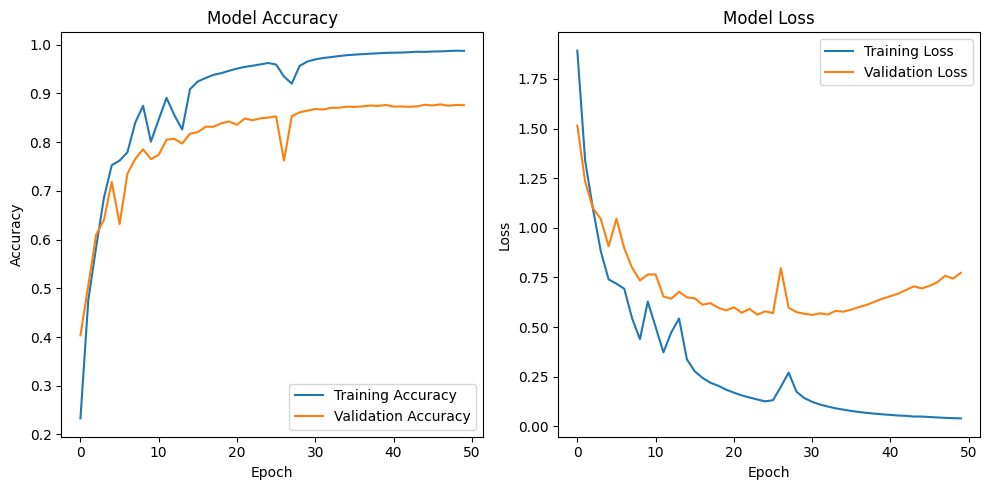

Classification Report:
              precision    recall  f1-score   support

       Angry       0.84      0.85      0.84      1510
     Disgust       0.90      0.94      0.92      1530
        Fear       0.97      1.00      0.99      1532
        Hate       0.96      1.00      0.98      1527
         Joy       0.75      0.53      0.62      1541
        Love       0.82      0.91      0.86      1560
     Sadness       0.80      0.78      0.79      1514
    Surprise       0.92      1.00      0.96      1557

    accuracy                           0.88     12271
   macro avg       0.87      0.88      0.87     12271
weighted avg       0.87      0.88      0.87     12271



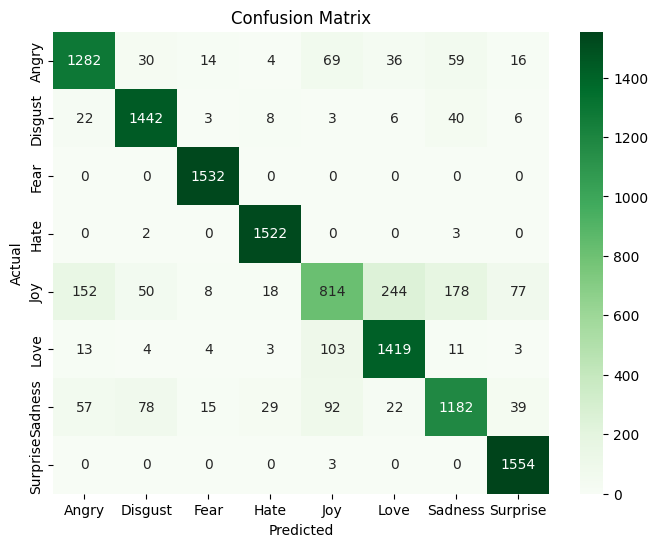

In [ ]:
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 2s 5ms/step


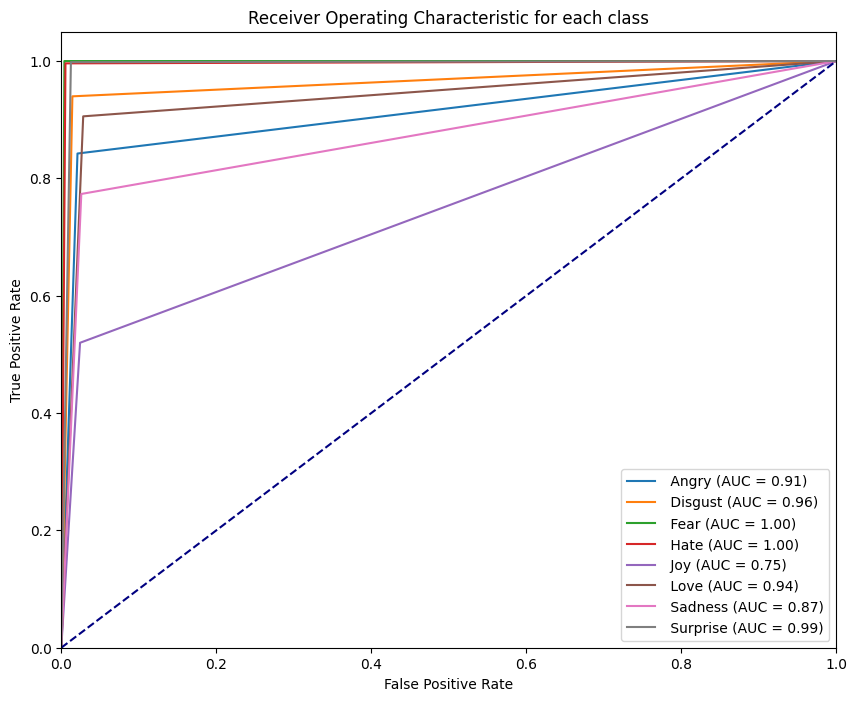

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


384/384 [==============================] - 2s 5ms/step


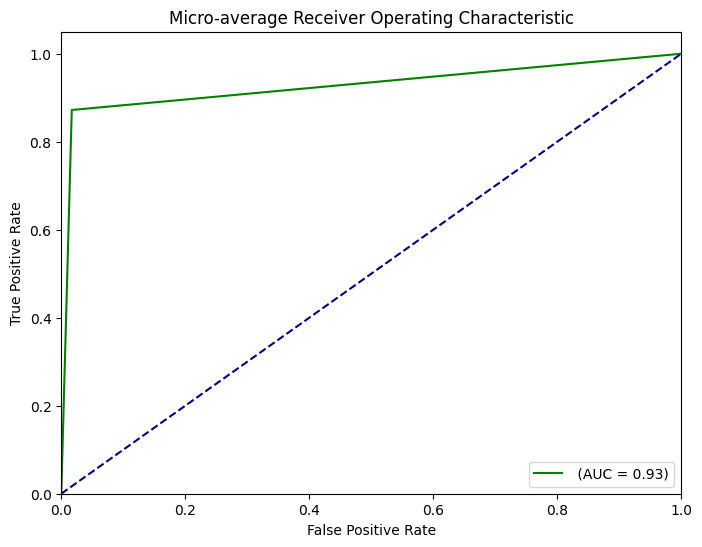

AUC =  0.9276051550112343


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


## CNN+LSTM

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Concatenate, concatenate
from keras.callbacks import ModelCheckpoint
embedding_dim = 128

input_shape = (max_sequence_length,)

cnn_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(cnn_input)
conv1 = Conv1D(128, 5, activation='relu')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten1 = Flatten()(pool1)

lstm_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(lstm_input)
lstm = LSTM(128)(embedding_layer)

merged = concatenate([flatten1, lstm])

dense_layer = Dense(128, activation='relu')(merged)
output = Dense(8, activation='softmax')(dense_layer)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 250)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 250, 128)             5104640   ['input_11[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 246, 128)             82048     ['embedding_10[0][0]']        
                                                                                                  
 input_12 (InputLayer)       [(None, 250)]                0         []                            
                                                                                            

In [ ]:
history = model.fit([X_train, X_train], y_train, epochs=50, batch_size=64, validation_data=([X_test, X_test], y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.6564
Epoch 1: val_accuracy improved from -inf to 0.85429, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 66s 82ms/step - loss: 0.9083 - accuracy: 0.6564 - val_loss: 0.4206 - val_accuracy: 0.8543
Epoch 2/50
765/767 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9321
Epoch 2: val_accuracy improved from 0.85429 to 0.90751, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5
767/767 [==============================] - 23s 30ms/step - loss: 0.2025 - accuracy: 0.9321 - val_loss: 0.3031 - val_accuracy: 0.9075
Epoch 3/50
766/767 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9819
Epoch 3: val_accuracy improved from 0.90751 to 0.91394, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5
767/767 [==============================] - 30s 39ms/step - loss: 0.0575 - accuracy: 0.9819 - val_loss: 0.3450 - val_accuracy: 0.9139
Epoch 4/50
766/767 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9931
Epoch 4: val_accuracy did not improve from 0.9139

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict([X_test, X_test])
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

384/384 [==============================] - 5s 6ms/step
Accuracy: 0.9108
Precision: 0.9091
Recall: 0.9108
F1-Score: 0.9089


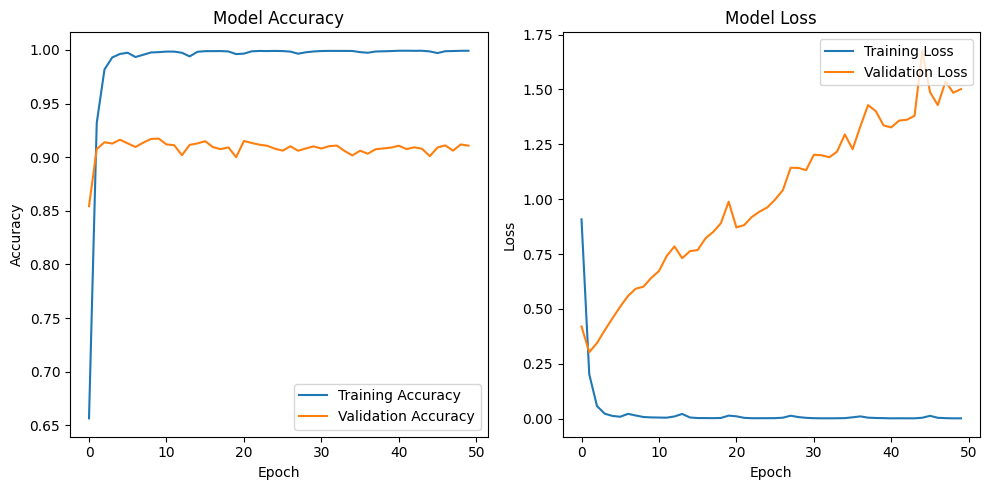

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.88      0.85      1510
     Disgust       0.93      0.96      0.95      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.99      1.00      0.99      1527
         Joy       0.80      0.69      0.74      1541
        Love       0.89      0.94      0.91      1560
     Sadness       0.87      0.80      0.84      1514
    Surprise       0.97      1.00      0.98      1557

    accuracy                           0.91     12271
   macro avg       0.91      0.91      0.91     12271
weighted avg       0.91      0.91      0.91     12271



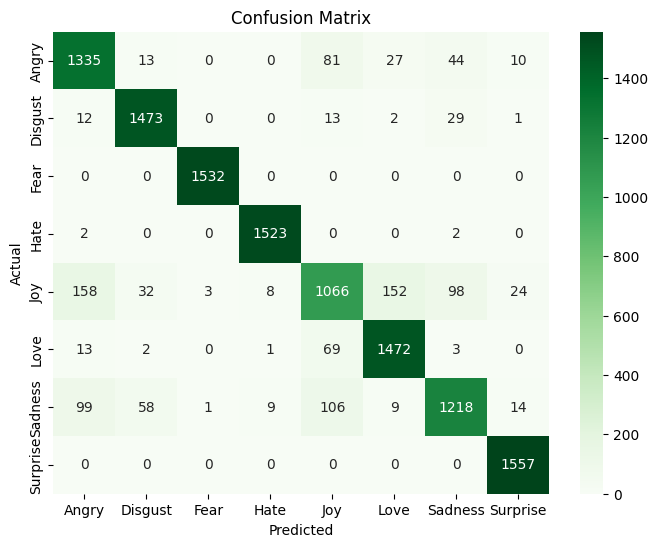

In [ ]:
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 9s 24ms/step


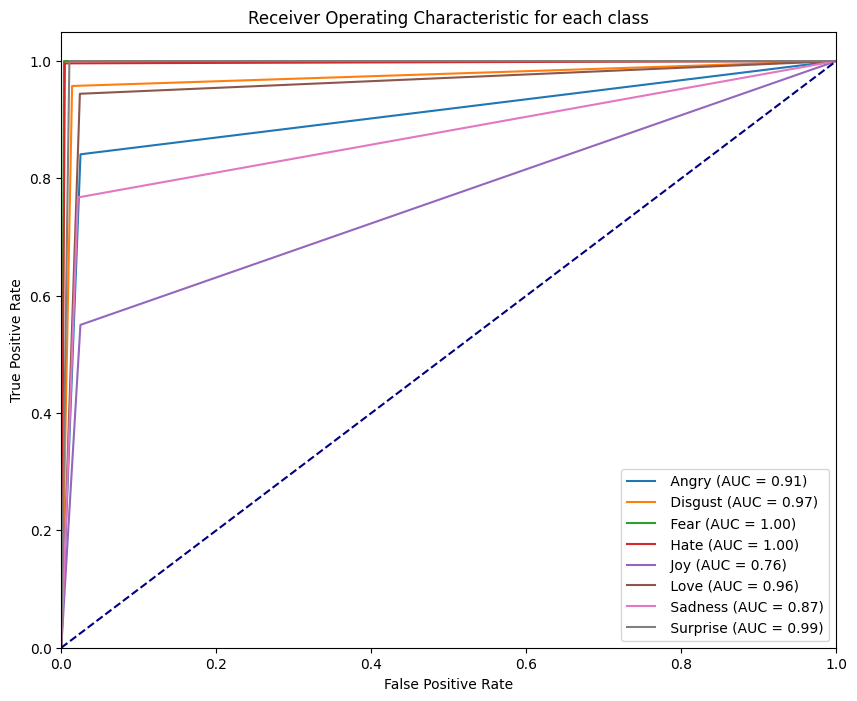

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

384/384 [==============================] - 8s 21ms/step


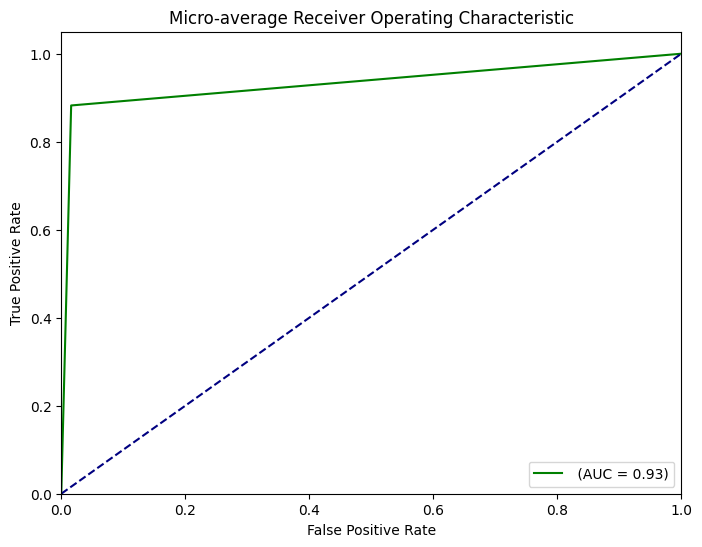

AUC =  0.9332339895456186


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))

#Without Oversampling

##Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Load the data

In [ ]:
df = pd.read_csv("/content/Emotion.csv")

In [ ]:
df.head()

ID                                               Data  Love  Joy  \
0   5454.0                             লকাল বাস ভালো এটা থেকে     0    0   
1  22549.0  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0   
2   7033.0  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0   
3  21114.0                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0   
4  23683.0                           সত্যিকার মানুষ তারাই ভাই     0    1   

   Surprise  Anger  Sadness  Fear  Disgust  Hate      Topic    Domain is_admin  
0       0.0      0        1     0      0.0     0     Travel   Youtube    False  
1       0.0      0        1     0      0.0     0   Politics   Youtube    False  
2       0.0      1        0     0      0.0     0   Personal  Facebook    False  
3       0.0      0        1     0      0.0     0  Education  Facebook    False  
4       0.0      0        0     0      0.0     0   Personal   Youtube    False

In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

Data  Love  Joy  Surprise  \
0                             লকাল বাস ভালো এটা থেকে     0    0       0.0   
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0       0.0   
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0       0.0   
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0       0.0   
4                           সত্যিকার মানুষ তারাই ভাই     0    1       0.0   

   Anger  Sadness  Fear  Disgust  Hate  
0      0        1     0      0.0     0  
1      0        1     0      0.0     0  
2      1        0     0      0.0     0  
3      0        1     0      0.0     0  
4      0        0     0      0.0     0

##Count class

In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


##Removing Rows which has muliple 1

In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

Data  Love  Joy  Surprise  \
0                             লকাল বাস ভালো এটা থেকে     0    0       0.0   
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...     0    0       0.0   
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...     0    0       0.0   
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন     0    0       0.0   
4                           সত্যিকার মানুষ তারাই ভাই     0    1       0.0   

   Anger  Sadness  Fear  Disgust  Hate    label  
0      0        1     0      0.0     0  Sadness  
1      0        1     0      0.0     0  Sadness  
2      1        0     0      0.0     0    Anger  
3      0        1     0      0.0     0  Sadness  
4      0        0     0      0.0     0      Joy

In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


## **Remove Unnecessary column**

In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy

In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

##Preprocessing

1. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Data'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Data']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 39880
Max sequence length: 250


##Target Column

In [ ]:
X = df['Data']
y = df['label']

##Keras Embedding

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
y = LabelEncoder().fit_transform(y)

##Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18300,) (4575,) (18300,) (4575,)


## ANN

### ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

# Assuming you have defined vocab_size, embedding_dim, and max_sequence_length
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())  # Flatten the embedded vectors
model.add(Dense(64, activation='relu'))  # Add a dense layer with 64 units and ReLU activation
model.add(Dense(32, activation='relu'))  # Add another dense layer with 32 units and ReLU activation
model.add(Dense(8, activation='softmax'))  # Output layer with 8 units and softmax activation


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2048064   
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
Total params: 7155048 (27.29 MB)
Trainable params: 7155048 (27.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
279/286 [============================>.] - ETA: 0s - loss: 1.5601 - accuracy: 0.4251
Epoch 1: val_accuracy improved from -inf to 0.54383, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 18s 60ms/step - loss: 1.5538 - accuracy: 0.4278 - val_loss: 1.2438 - val_accuracy: 0.5438
Epoch 2/50
285/286 [============================>.] - ETA: 0s - loss: 0.9536 - accuracy: 0.6728
Epoch 2: val_accuracy improved from 0.54383 to 0.61268, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5
286/286 [==============================] - 7s 23ms/step - loss: 0.9534 - accuracy: 0.6727 - val_loss: 1.1292 - val_accuracy: 0.6127
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8628
Epoch 3: val_accuracy did not improve from 0.61268
286/286 [==============================] - 5s 18ms/step - loss: 0.4356 - accuracy: 0.8626 - val_loss: 1.3766 - val_accuracy: 0.5910
Epoch 4/50
285/286 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9518
Epoch 4: val_accuracy did not improve from 0.61268
286/286 [==============================] - 7s 24ms/step - loss: 0.1598 - accuracy: 0.

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.5207
Precision: 0.5366
Recall: 0.5207
F1-Score: 0.5270


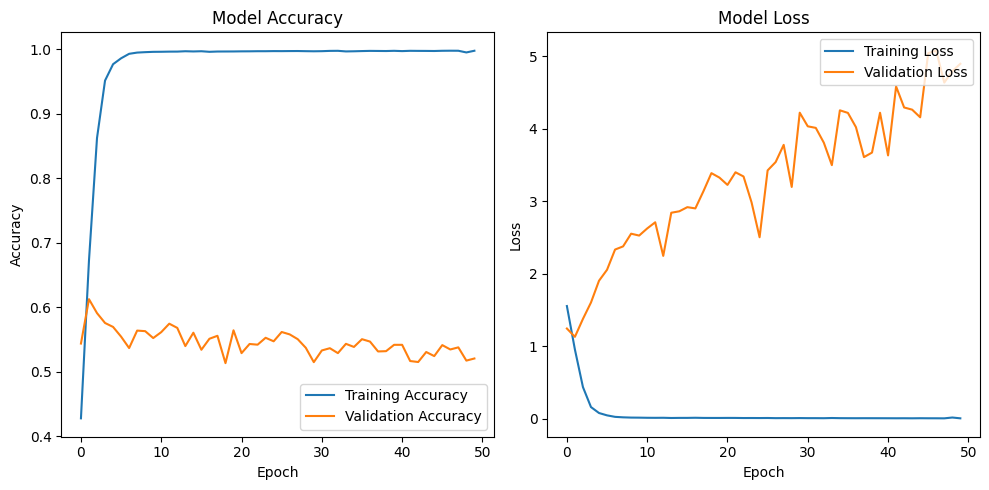

Classification Report:
              precision    recall  f1-score   support

       Angry       0.41      0.44      0.43       711
     Disgust       0.29      0.31      0.30       395
        Fear       0.06      0.04      0.05        45
        Hate       0.87      0.74      0.80       305
         Joy       0.65      0.63      0.64      1593
        Love       0.34      0.42      0.38       462
     Sadness       0.61      0.53      0.57       928
    Surprise       0.14      0.18      0.16       136

    accuracy                           0.52      4575
   macro avg       0.42      0.41      0.41      4575
weighted avg       0.54      0.52      0.53      4575



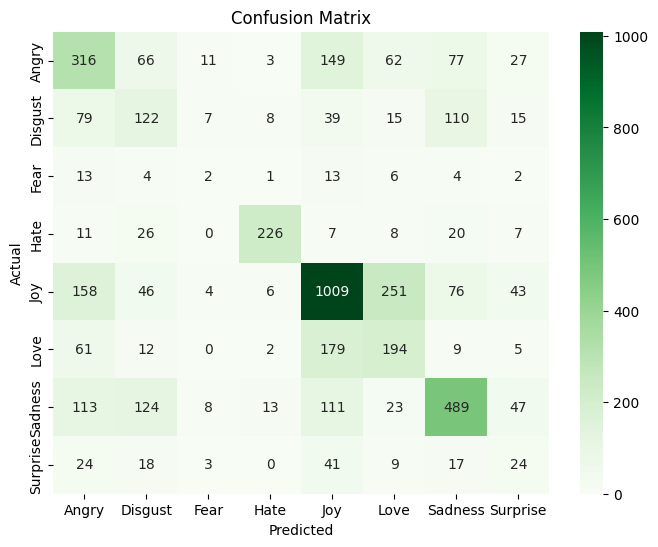

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


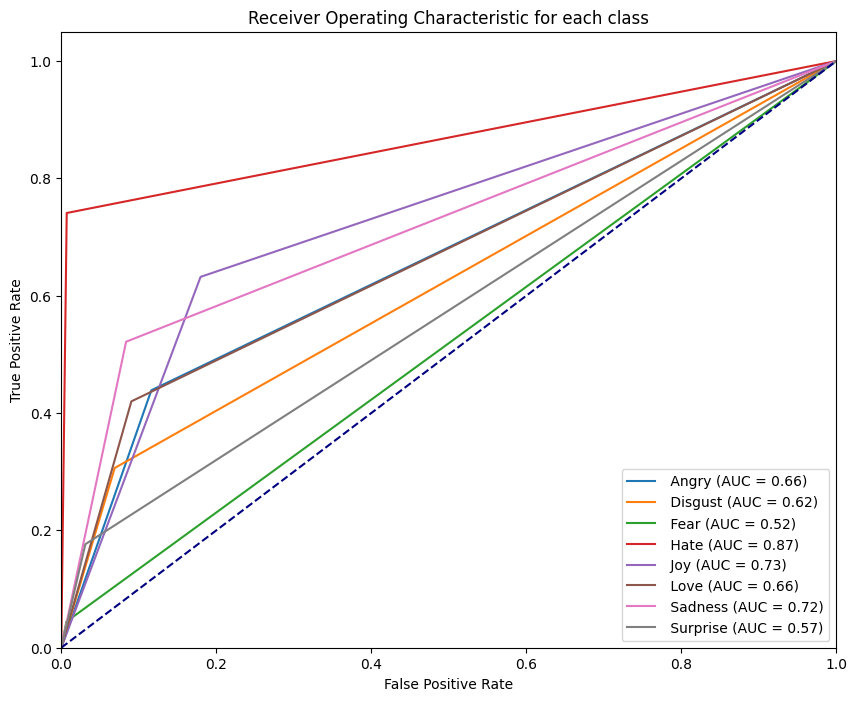

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 3ms/step


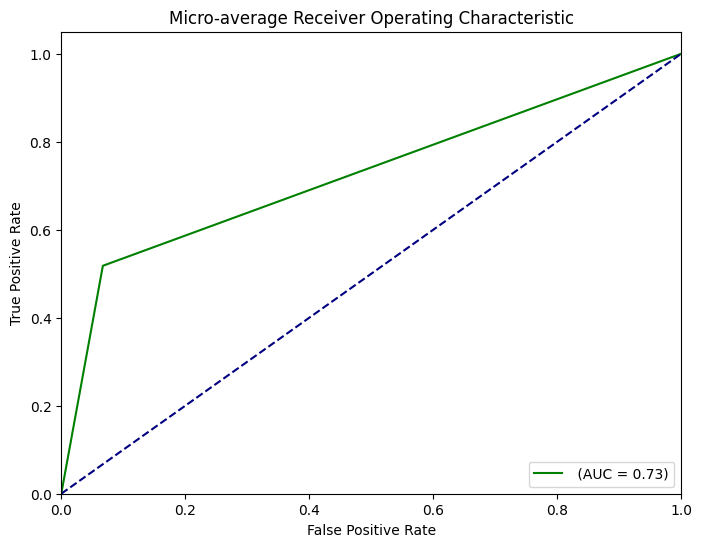

AUC =  0.725480093676815


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

143/143 [==============================] - 1s 4ms/step
Accuracy: 0.6129
Precision: 0.5983
Recall: 0.6129
F1-Score: 0.5896


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


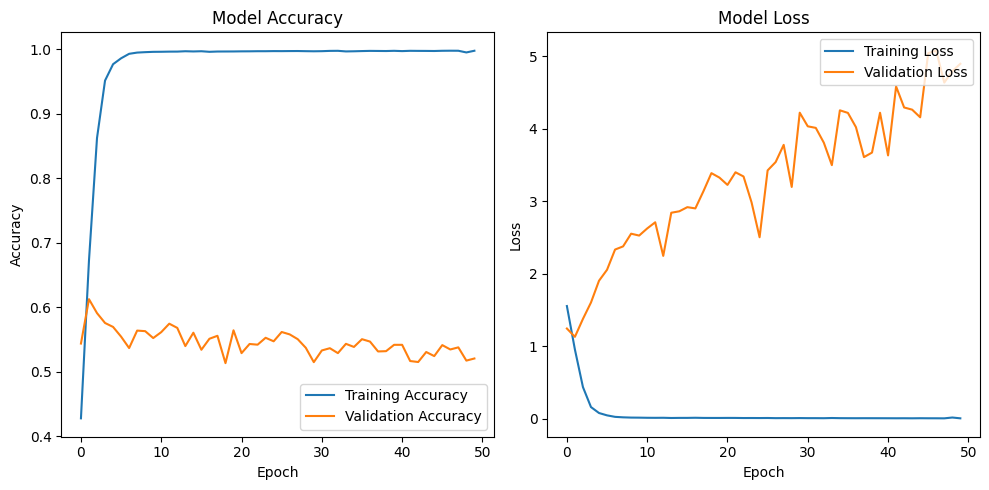

Classification Report:
              precision    recall  f1-score   support

       Angry       0.43      0.57      0.49       711
     Disgust       0.56      0.37      0.45       395
        Fear       0.00      0.00      0.00        45
        Hate       0.91      0.81      0.86       305
         Joy       0.65      0.81      0.72      1593
        Love       0.65      0.24      0.35       462
     Sadness       0.64      0.64      0.64       928
    Surprise       0.00      0.00      0.00       136

    accuracy                           0.61      4575
   macro avg       0.48      0.43      0.44      4575
weighted avg       0.60      0.61      0.59      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


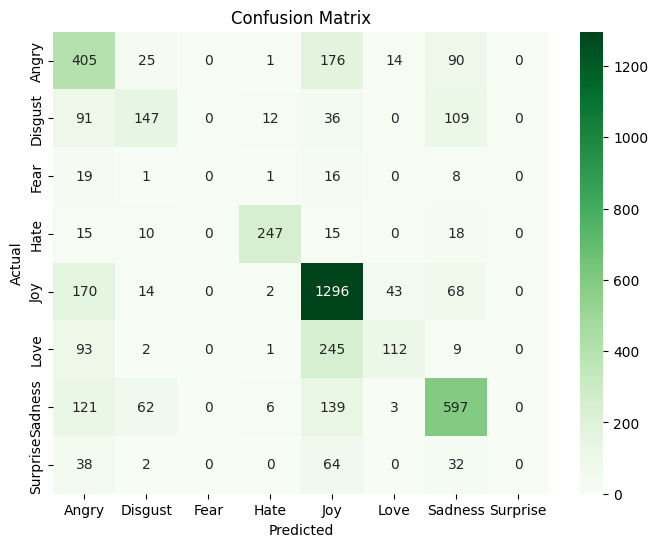

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/ANN/best_model_new1.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


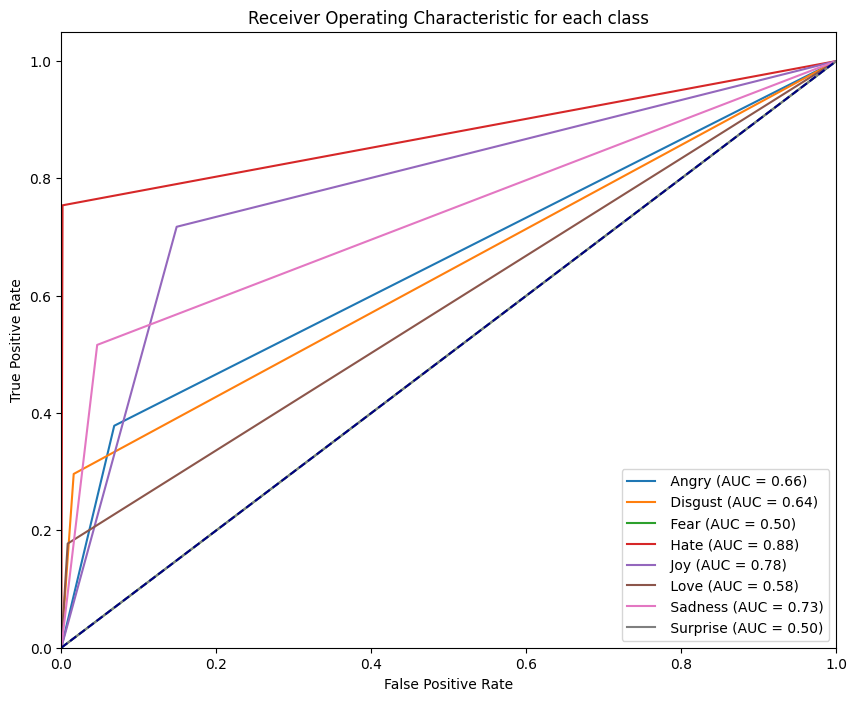

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


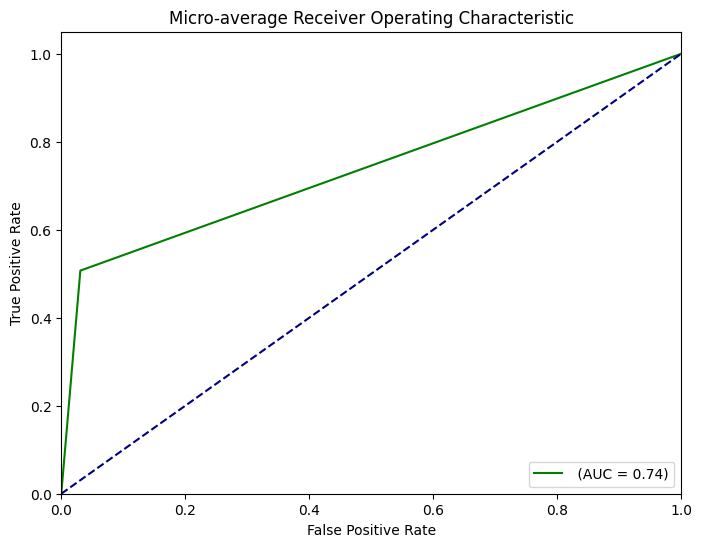

AUC =  0.7381733021077284


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Using L2

### ANN using l2

In [ ]:
from tensorflow.keras import regularizers

# Assuming you have defined vocab_size, embedding_dim, and max_sequence_length
embedding_dim = 128
l2_regularizer = regularizers.l2(0.01)  # Define L2 regularization with a regularization strength of 0.01

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())  # Flatten the embedded vectors
model.add(Dense(64, activation='relu', kernel_regularizer=l2_regularizer))  # Add a dense layer with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2_regularizer))  # Add another dense layer with L2 regularization
model.add(Dense(8, activation='softmax'))  # Output layer with 8 units and softmax activation


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/ANN/best_model_new2.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 flatten_3 (Flatten)         (None, 32000)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                2048064   
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
Total params: 7155048 (27.29 MB)
Trainable params: 7155048 (27.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
280/286 [============================>.] - ETA: 0s - loss: 1.8992 - accuracy: 0.3973
Epoch 1: val_accuracy improved from -inf to 0.46295, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2.h5
286/286 [==============================] - 27s 87ms/step - loss: 1.8924 - accuracy: 0.3989 - val_loss: 1.5889 - val_accuracy: 0.4630
Epoch 2/50
  1/286 [..............................] - ETA: 4s - loss: 1.5778 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/286 [============================>.] - ETA: 0s - loss: 1.4517 - accuracy: 0.5088
Epoch 2: val_accuracy improved from 0.46295 to 0.47410, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2.h5
286/286 [==============================] - 7s 24ms/step - loss: 1.4514 - accuracy: 0.5080 - val_loss: 1.5076 - val_accuracy: 0.4741
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 1.2386 - accuracy: 0.5979
Epoch 3: val_accuracy improved from 0.47410 to 0.53421, saving model to /content/drive/MyDrive/Model/Opu/ANN/best_model_new2.h5
286/286 [==============================] - 4s 13ms/step - loss: 1.2383 - accuracy: 0.5978 - val_loss: 1.4371 - val_accuracy: 0.5342
Epoch 4/50
279/286 [============================>.] - ETA: 0s - loss: 1.0557 - accuracy: 0.6767
Epoch 4: val_accuracy did not improve from 0.53421
286/286 [==============================] - 3s 9ms/step - loss: 1.0546 - accuracy: 0.6770 - val_loss: 1.4938 - val_accuracy: 0.5318
Epoch 5/50
282/286 [=

143/143 [==============================] - 0s 1ms/step
Accuracy: 0.4647
Precision: 0.5206
Recall: 0.4647
F1-Score: 0.4776


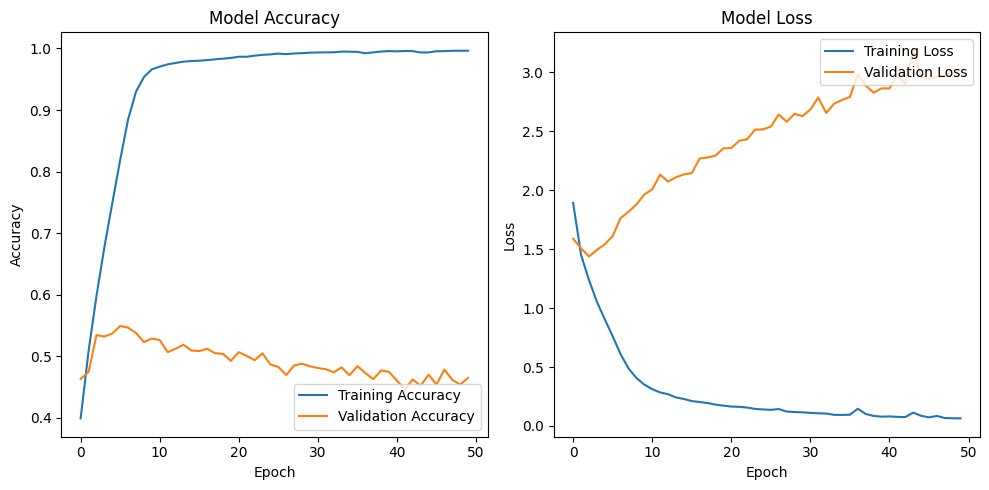

Classification Report:
              precision    recall  f1-score   support

       Angry       0.32      0.42      0.37       711
     Disgust       0.42      0.16      0.23       395
        Fear       0.02      0.18      0.04        45
        Hate       0.93      0.41      0.56       305
         Joy       0.64      0.62      0.63      1593
        Love       0.43      0.27      0.33       462
     Sadness       0.51      0.54      0.53       928
    Surprise       0.10      0.10      0.10       136

    accuracy                           0.46      4575
   macro avg       0.42      0.34      0.35      4575
weighted avg       0.52      0.46      0.48      4575



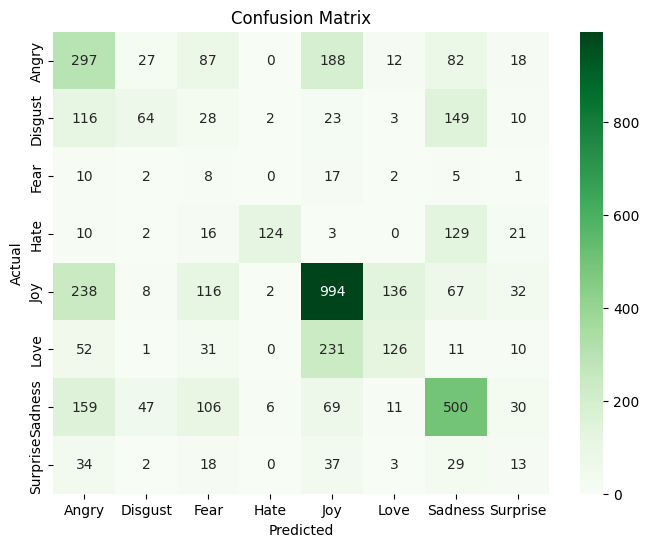

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


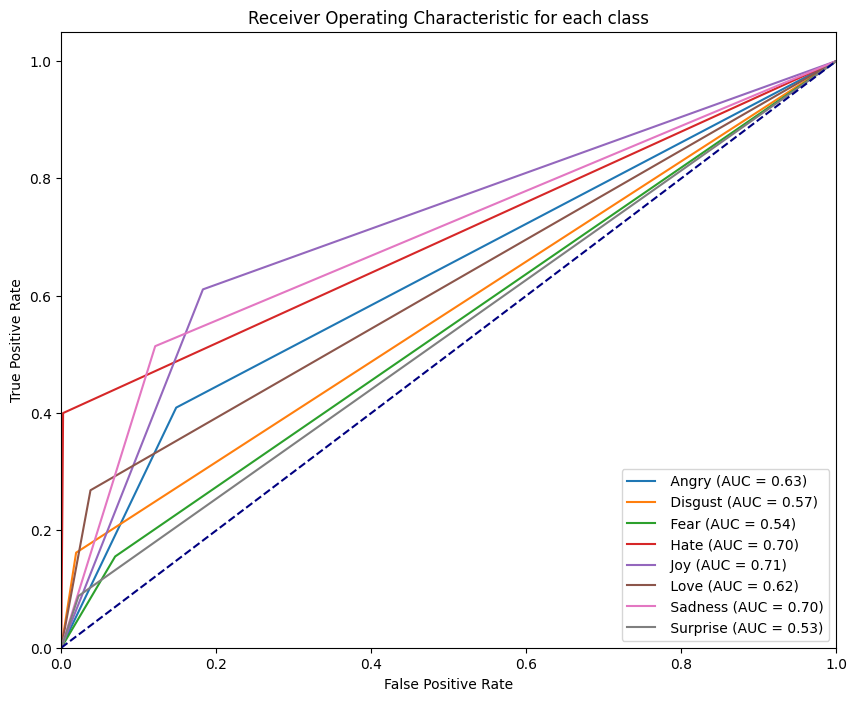

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


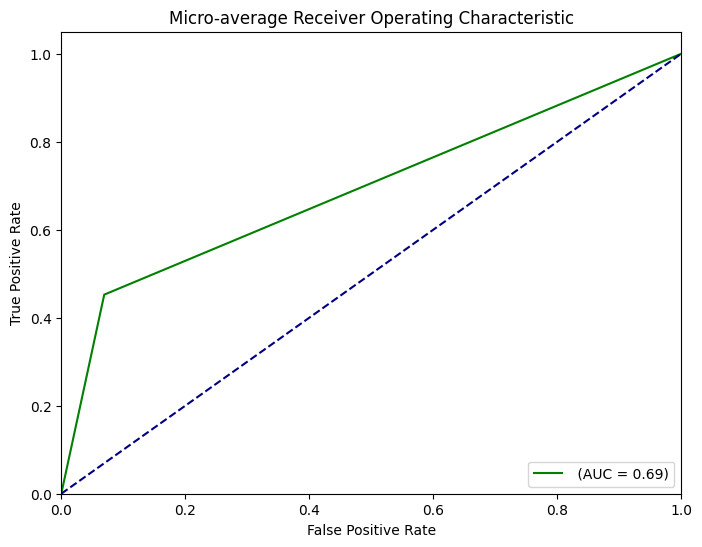

AUC =  0.6915846994535519


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

143/143 [==============================] - 0s 1ms/step
Accuracy: 0.5491
Precision: 0.5618
Recall: 0.5491
F1-Score: 0.5433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


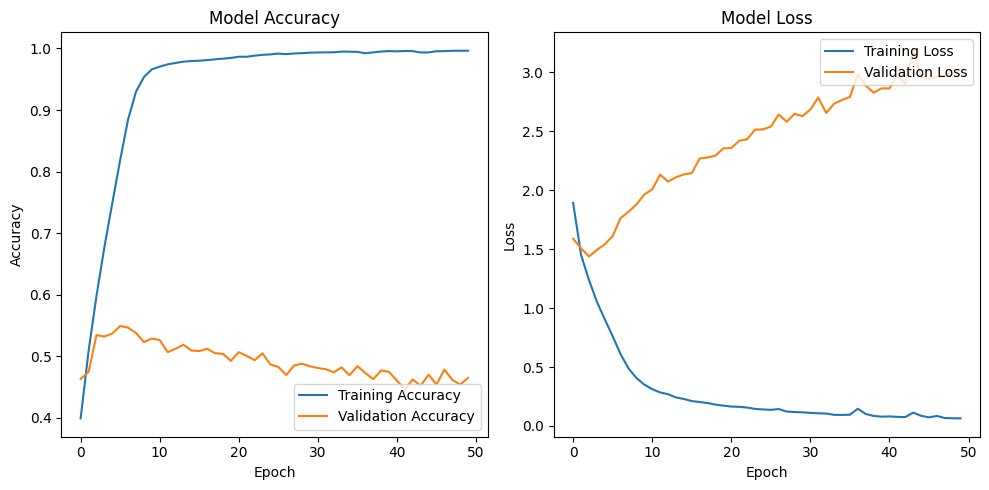

Classification Report:
              precision    recall  f1-score   support

       Angry       0.33      0.54      0.41       711
     Disgust       0.49      0.26      0.34       395
        Fear       0.00      0.00      0.00        45
        Hate       0.91      0.70      0.79       305
         Joy       0.69      0.69      0.69      1593
        Love       0.57      0.33      0.41       462
     Sadness       0.53      0.59      0.56       928
    Surprise       0.09      0.04      0.05       136

    accuracy                           0.55      4575
   macro avg       0.45      0.39      0.41      4575
weighted avg       0.56      0.55      0.54      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


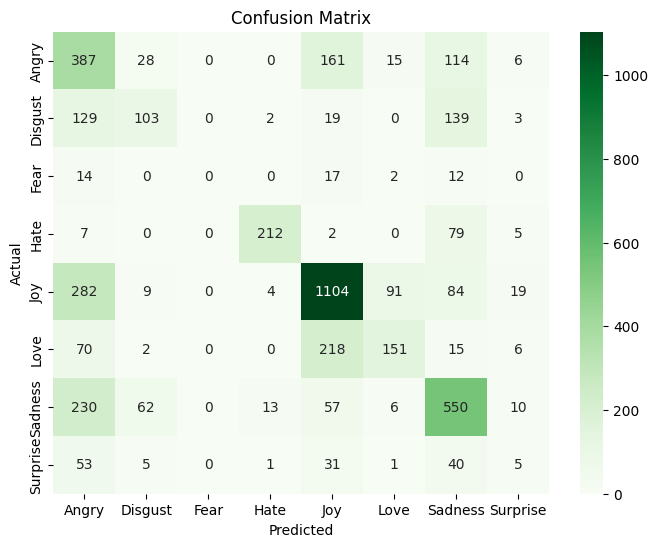

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/ANN/best_model_new2.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


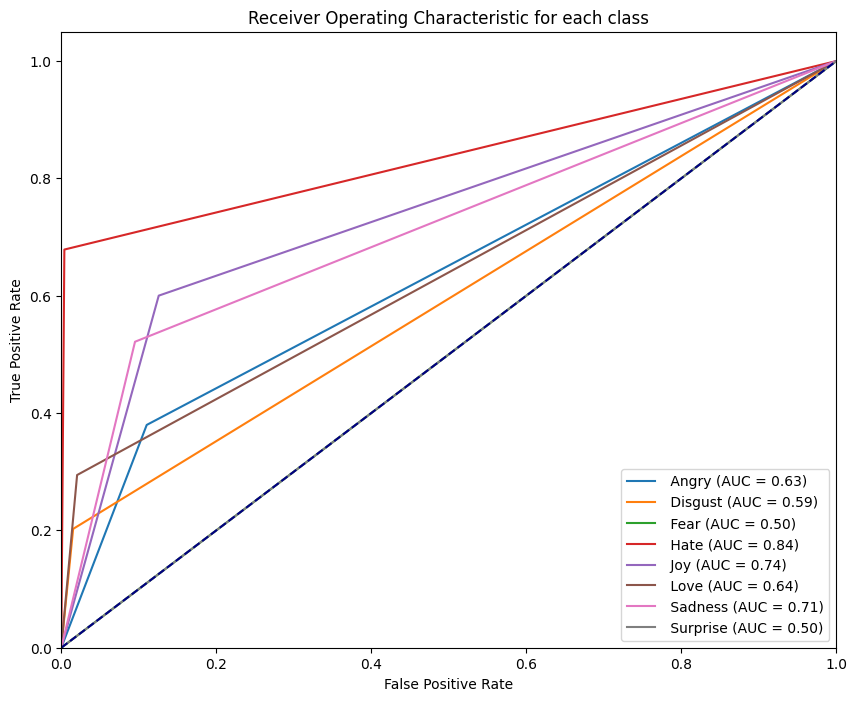

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


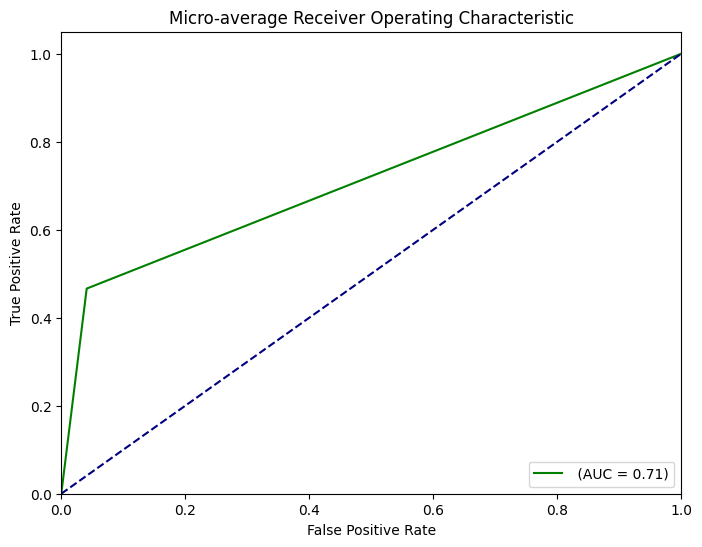

AUC =  0.7126151444184231


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


##CNN

### CNN

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_4 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
282/286 [============================>.] - ETA: 0s - loss: 1.5142 - accuracy: 0.4379
Epoch 1: val_accuracy improved from -inf to 0.55191, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 21s 71ms/step - loss: 1.5107 - accuracy: 0.4390 - val_loss: 1.2086 - val_accuracy: 0.5519
Epoch 2/50
284/286 [============================>.] - ETA: 0s - loss: 0.9512 - accuracy: 0.6641
Epoch 2: val_accuracy improved from 0.55191 to 0.61224, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5
286/286 [==============================] - 8s 27ms/step - loss: 0.9508 - accuracy: 0.6644 - val_loss: 1.1169 - val_accuracy: 0.6122
Epoch 3/50
281/286 [============================>.] - ETA: 0s - loss: 0.5134 - accuracy: 0.8337
Epoch 3: val_accuracy did not improve from 0.61224
286/286 [==============================] - 4s 15ms/step - loss: 0.5127 - accuracy: 0.8336 - val_loss: 1.2759 - val_accuracy: 0.6035
Epoch 4/50
284/286 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy: 0.9239
Epoch 4: val_accuracy did not improve from 0.61224
286/286 [==============================] - 3s 12ms/step - loss: 0.2502 - accuracy: 0.9

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.5596
Precision: 0.5599
Recall: 0.5596
F1-Score: 0.5587


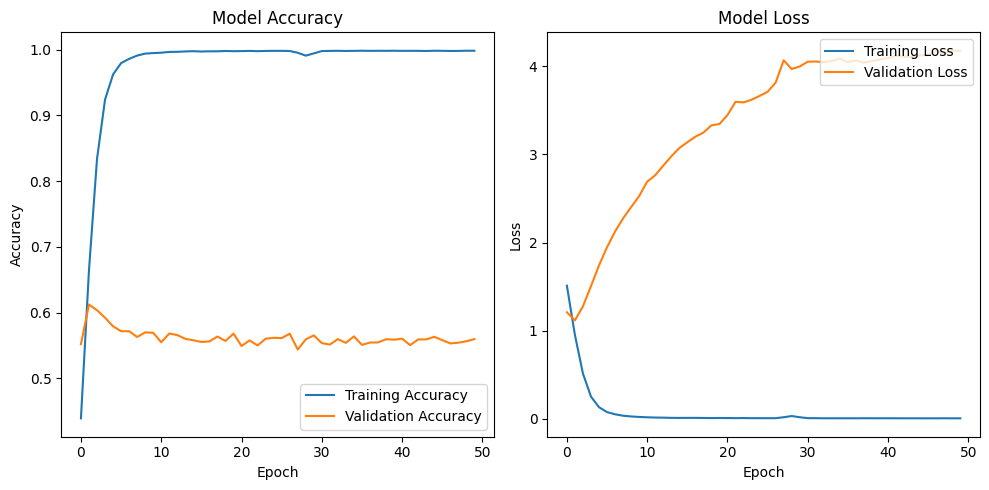

Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.46      0.46       711
     Disgust       0.41      0.41      0.41       395
        Fear       0.12      0.11      0.12        45
        Hate       0.86      0.73      0.79       305
         Joy       0.65      0.71      0.68      1593
        Love       0.40      0.37      0.38       462
     Sadness       0.60      0.55      0.58       928
    Surprise       0.19      0.21      0.20       136

    accuracy                           0.56      4575
   macro avg       0.46      0.44      0.45      4575
weighted avg       0.56      0.56      0.56      4575



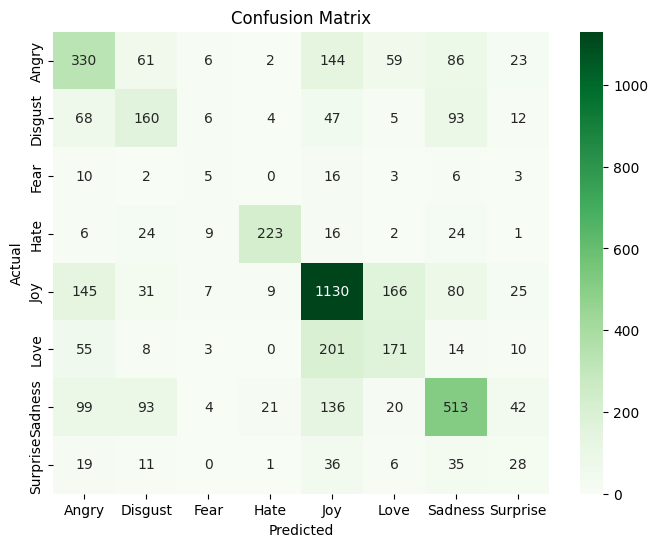

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 3ms/step


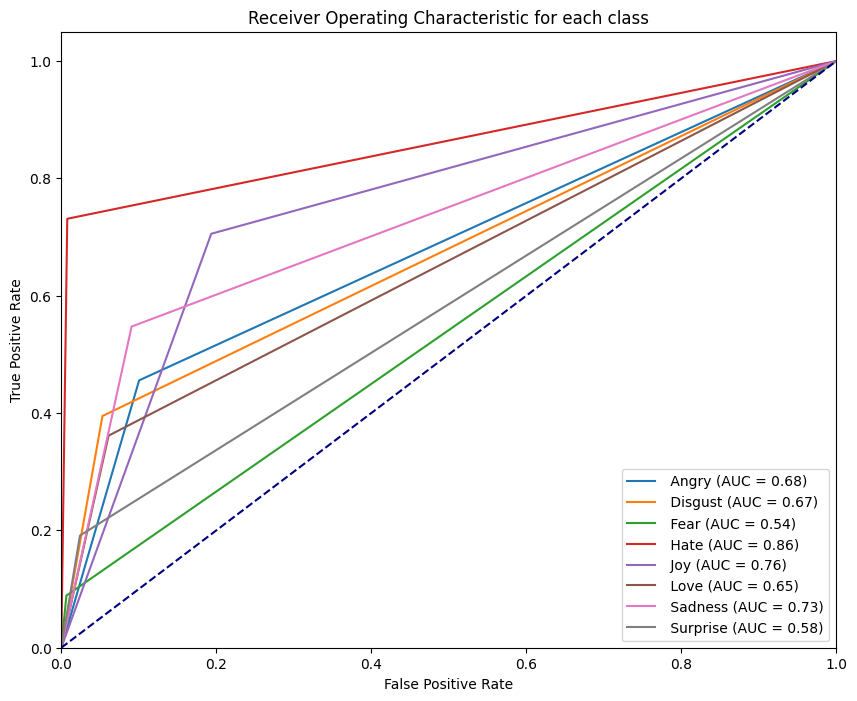

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


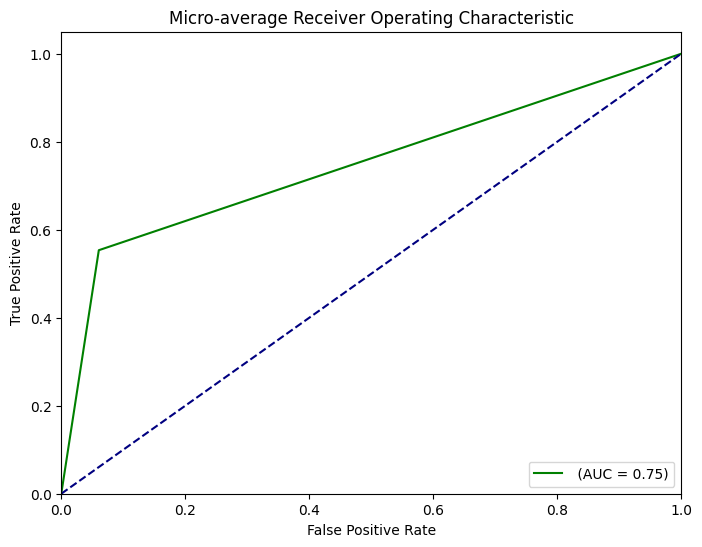

AUC =  0.746448087431694


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

143/143 [==============================] - 0s 3ms/step
Accuracy: 0.6122
Precision: 0.5999
Recall: 0.6122
F1-Score: 0.5806


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


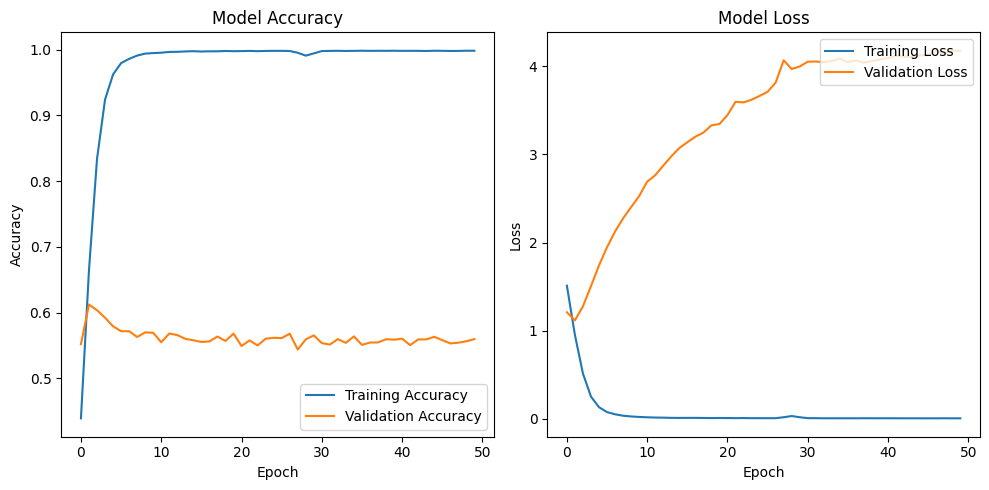

Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.54      0.49       711
     Disgust       0.67      0.26      0.38       395
        Fear       0.00      0.00      0.00        45
        Hate       0.90      0.84      0.87       305
         Joy       0.64      0.83      0.73      1593
        Love       0.68      0.22      0.33       462
     Sadness       0.60      0.68      0.63       928
    Surprise       0.00      0.00      0.00       136

    accuracy                           0.61      4575
   macro avg       0.49      0.42      0.43      4575
weighted avg       0.60      0.61      0.58      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


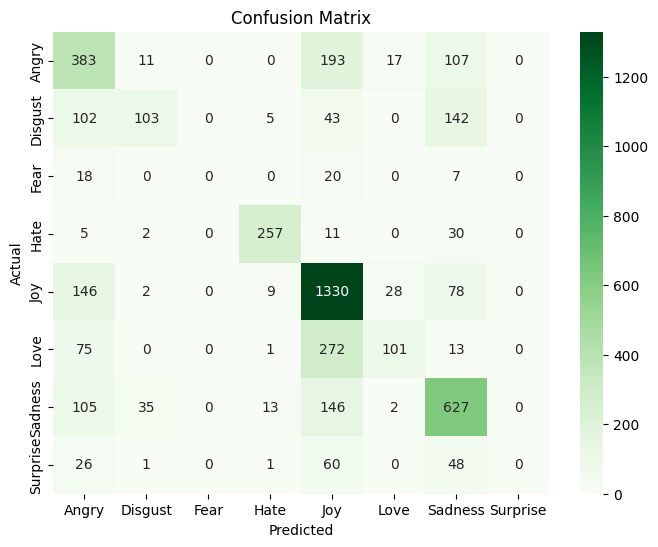

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 3ms/step


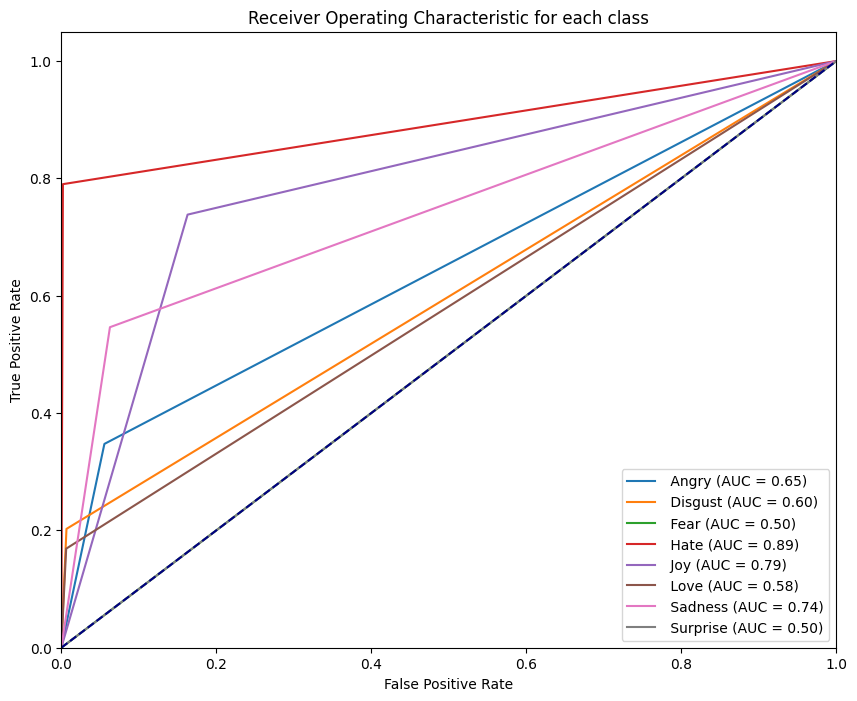

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 3ms/step


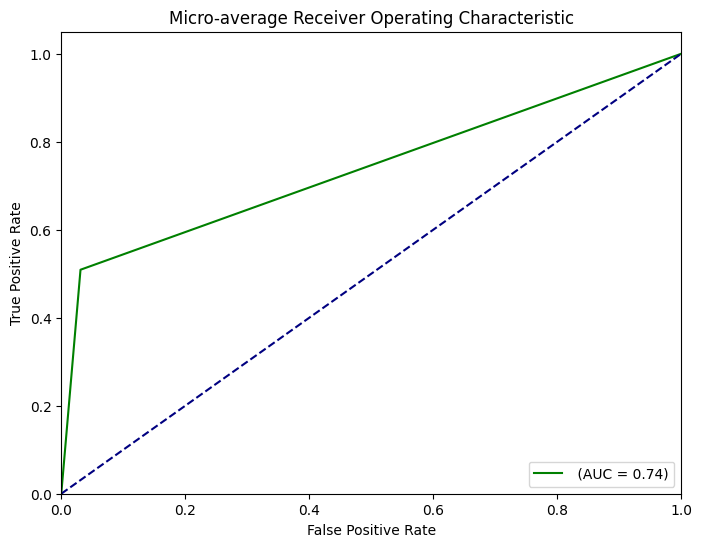

AUC =  0.739032006245121


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


Using L2

### CNN using l2

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_3 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7936)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
282/286 [============================>.] - ETA: 0s - loss: 1.8170 - accuracy: 0.3995
Epoch 1: val_accuracy improved from -inf to 0.47716, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 21s 67ms/step - loss: 1.8131 - accuracy: 0.4008 - val_loss: 1.5233 - val_accuracy: 0.4772
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/286 [============================>.] - ETA: 0s - loss: 1.4275 - accuracy: 0.5137
Epoch 2: val_accuracy improved from 0.47716 to 0.49945, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 7s 23ms/step - loss: 1.4296 - accuracy: 0.5129 - val_loss: 1.4555 - val_accuracy: 0.4995
Epoch 3/50
286/286 [==============================] - ETA: 0s - loss: 1.2969 - accuracy: 0.5859
Epoch 3: val_accuracy improved from 0.49945 to 0.51104, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 5s 16ms/step - loss: 1.2969 - accuracy: 0.5859 - val_loss: 1.4694 - val_accuracy: 0.5110
Epoch 4/50
276/286 [===========================>..] - ETA: 0s - loss: 1.2049 - accuracy: 0.6401
Epoch 4: val_accuracy improved from 0.51104 to 0.51191, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 4s 14ms/step - loss: 1.2049 - ac

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.4936
Precision: 0.4961
Recall: 0.4936
F1-Score: 0.4907


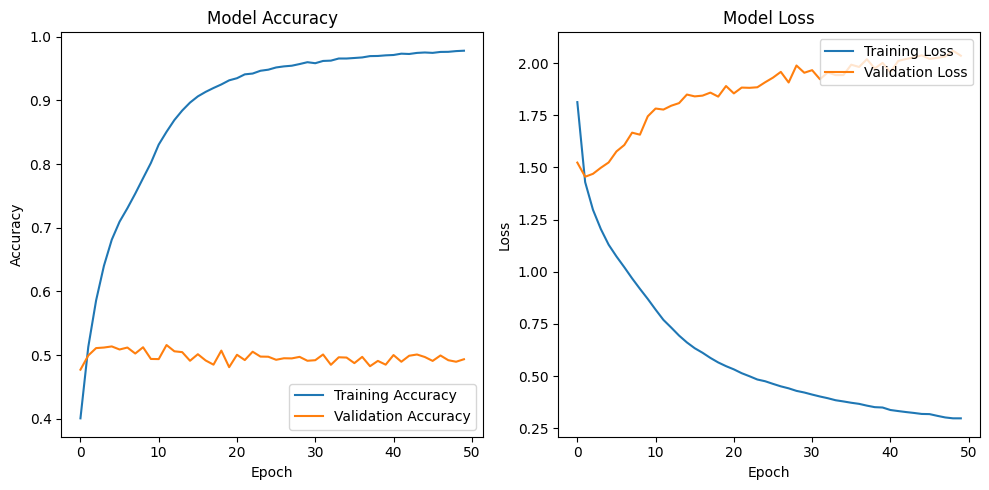

Classification Report:
              precision    recall  f1-score   support

       Angry       0.38      0.44      0.41       711
     Disgust       0.29      0.24      0.26       395
        Fear       0.17      0.02      0.04        45
        Hate       0.90      0.57      0.70       305
         Joy       0.63      0.66      0.64      1593
        Love       0.31      0.27      0.29       462
     Sadness       0.47      0.53      0.50       928
    Surprise       0.13      0.12      0.12       136

    accuracy                           0.49      4575
   macro avg       0.41      0.36      0.37      4575
weighted avg       0.50      0.49      0.49      4575



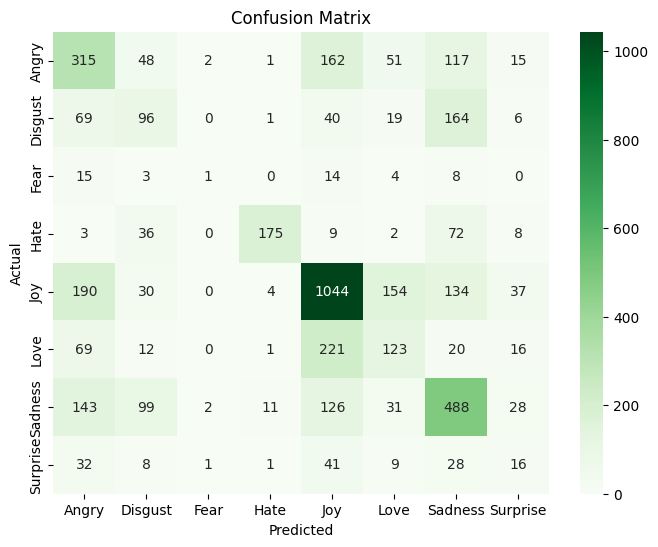

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


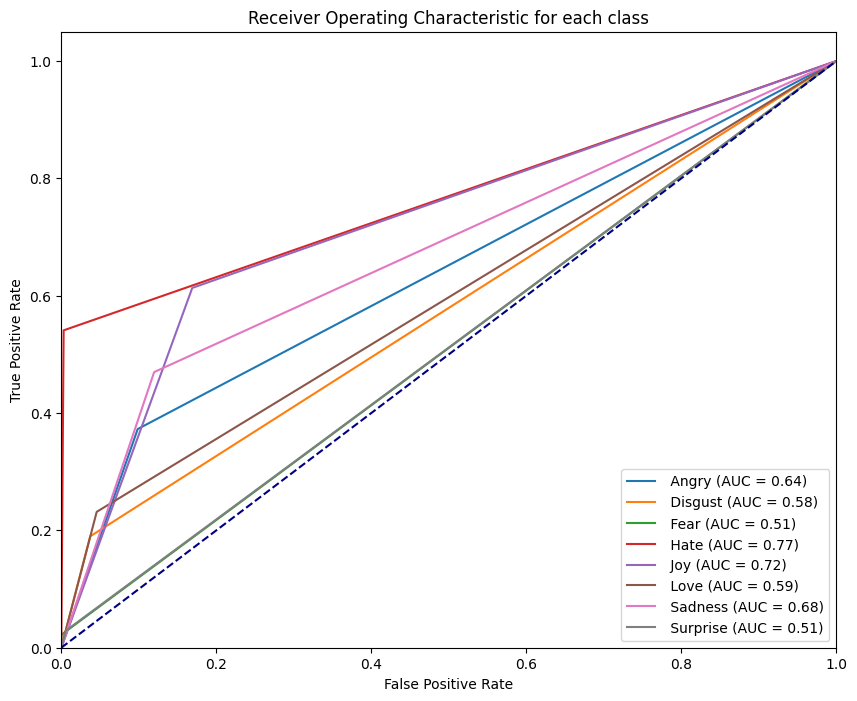

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


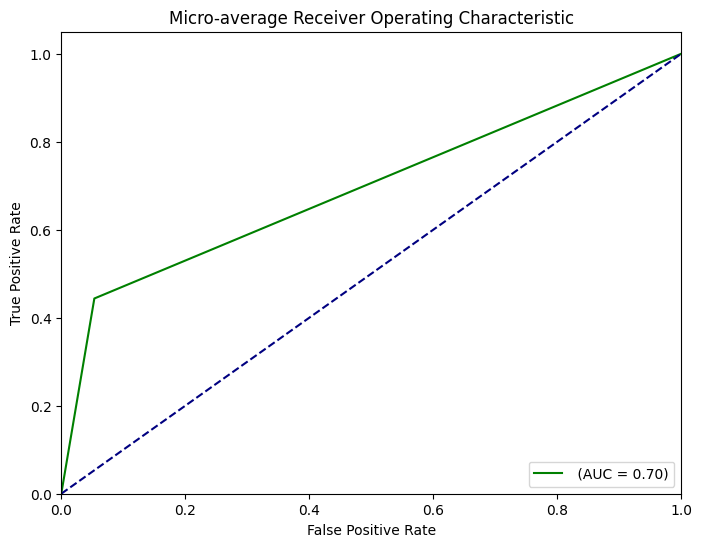

AUC =  0.6951912568306011


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


using best model

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.5158
Precision: 0.4899
Recall: 0.5158
F1-Score: 0.4898


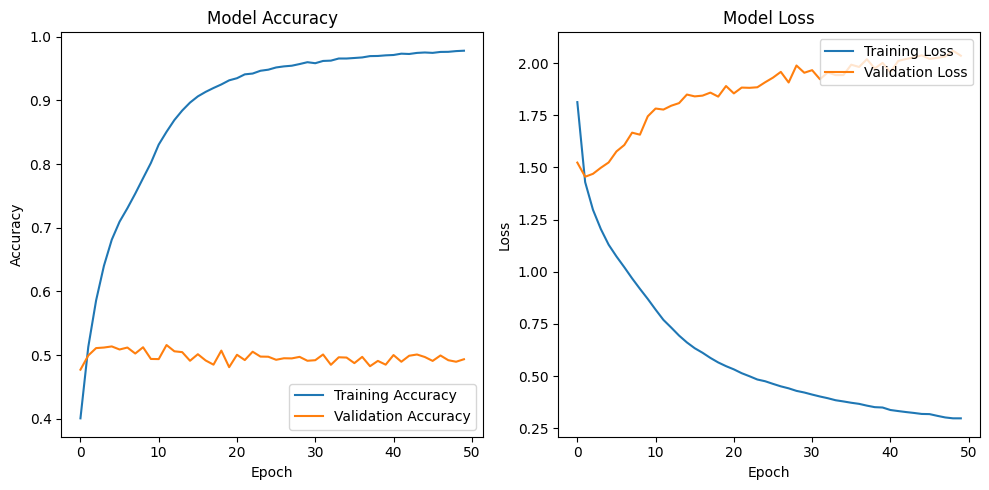

Classification Report:
              precision    recall  f1-score   support

       Angry       0.37      0.32      0.34       711
     Disgust       0.41      0.17      0.25       395
        Fear       0.00      0.00      0.00        45
        Hate       0.90      0.63      0.74       305
         Joy       0.61      0.76      0.67      1593
        Love       0.28      0.19      0.23       462
     Sadness       0.46      0.62      0.53       928
    Surprise       0.12      0.03      0.05       136

    accuracy                           0.52      4575
   macro avg       0.39      0.34      0.35      4575
weighted avg       0.49      0.52      0.49      4575



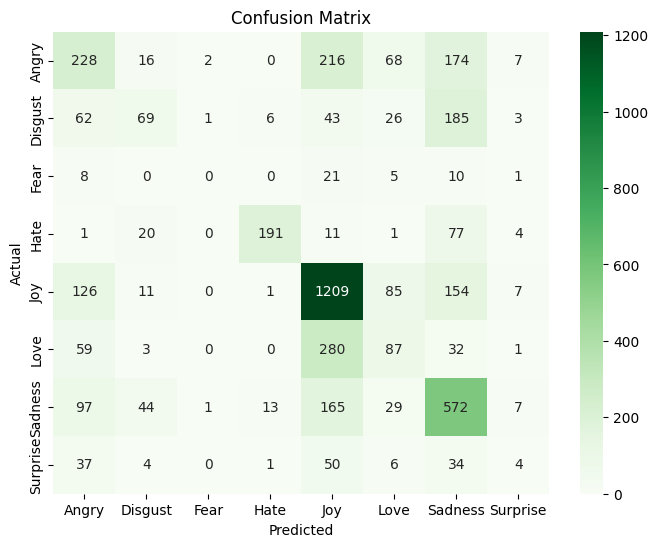

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 0s 2ms/step


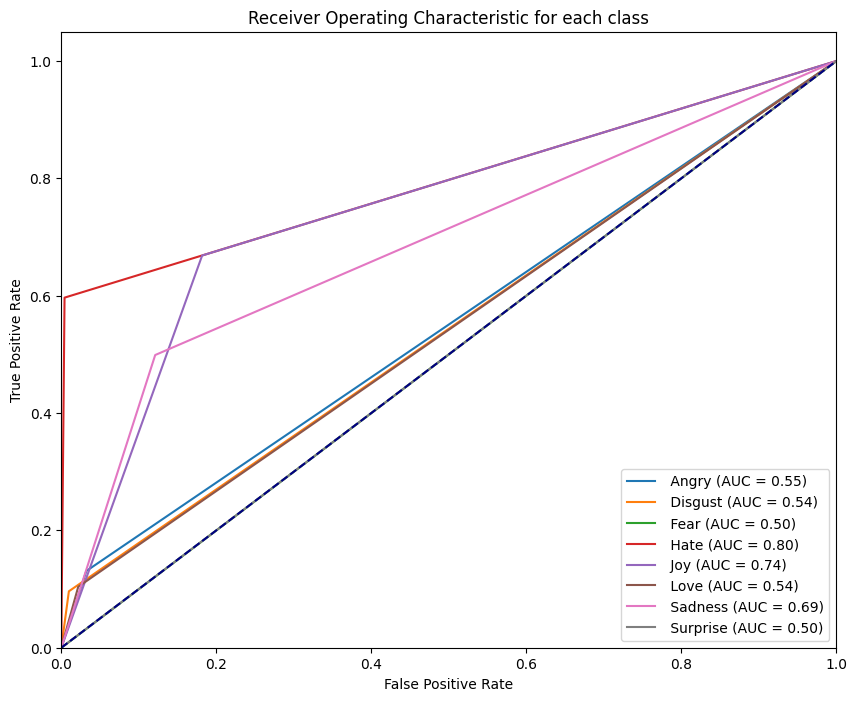

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 0s 2ms/step


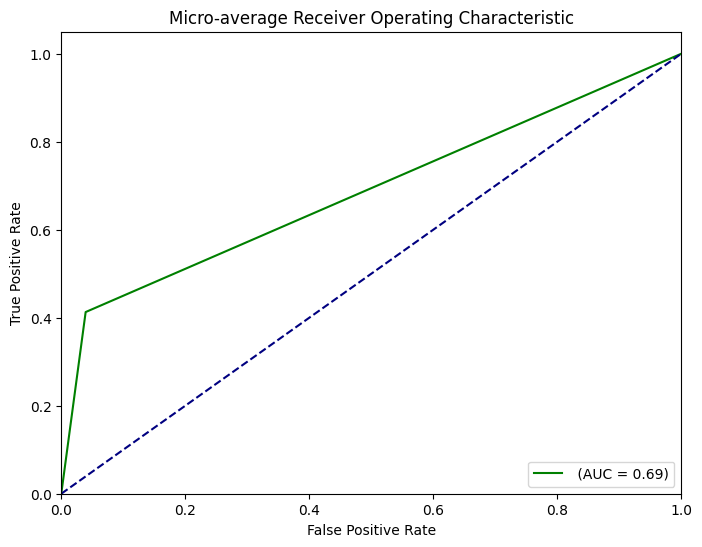

AUC =  0.686791569086651


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


## Bi-Lstm

### **Bi-LSTM 90**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define parameters
embedding_dim = 128

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Flatten())  # Flatten layer
model.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/BiLSTM/best_model_new1_withoutOversampling.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 bidirectional_1 (Bidirecti  (None, 250, 128)          98816     
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_1 (Dense)             (None, 8)                 256008    
                                                                 
Total params: 5459464 (20.83 MB)
Trainable params: 5459464 (20.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
285/286 [============================>.] - ETA: 0s - loss: 1.3616 - accuracy: 0.4993
Epoch 1: val_accuracy improved from -inf to 0.61333, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1_withoutOversampling.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 34s 99ms/step - loss: 1.3612 - accuracy: 0.4997 - val_loss: 1.0925 - val_accuracy: 0.6133
Epoch 2/50
285/286 [============================>.] - ETA: 0s - loss: 0.7626 - accuracy: 0.7394
Epoch 2: val_accuracy improved from 0.61333 to 0.61967, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new1_withoutOversampling.h5
286/286 [==============================] - 13s 45ms/step - loss: 0.7616 - accuracy: 0.7397 - val_loss: 1.1504 - val_accuracy: 0.6197
Epoch 3/50
284/286 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8834
Epoch 3: val_accuracy did not improve from 0.61967
286/286 [==============================] - 8s 28ms/step - loss: 0.3419 - accuracy: 0.8838 - val_loss: 1.4203 - val_accuracy: 0.6042
Epoch 4/50
285/286 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9501
Epoch 4: val_accuracy did not improve from 0.61967
286/286 [==============================] - 8s 28ms/step - los

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


143/143 [==============================] - 3s 12ms/step
Accuracy: 0.5460
Precision: 0.5606
Recall: 0.5460
F1-Score: 0.5508


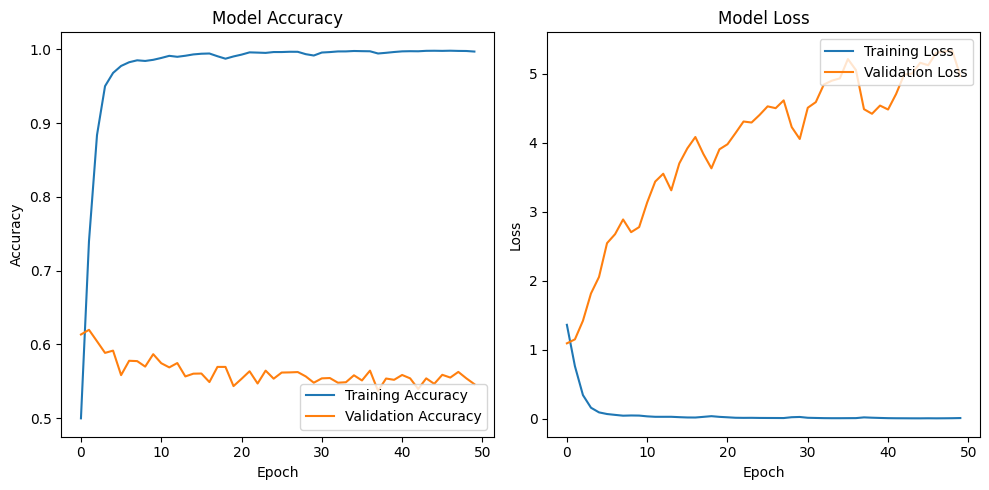

Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.51      0.48       711
     Disgust       0.48      0.31      0.38       395
        Fear       0.07      0.11      0.09        45
        Hate       0.84      0.80      0.82       305
         Joy       0.66      0.65      0.65      1593
        Love       0.36      0.40      0.38       462
     Sadness       0.61      0.55      0.58       928
    Surprise       0.14      0.23      0.18       136

    accuracy                           0.55      4575
   macro avg       0.45      0.45      0.44      4575
weighted avg       0.56      0.55      0.55      4575



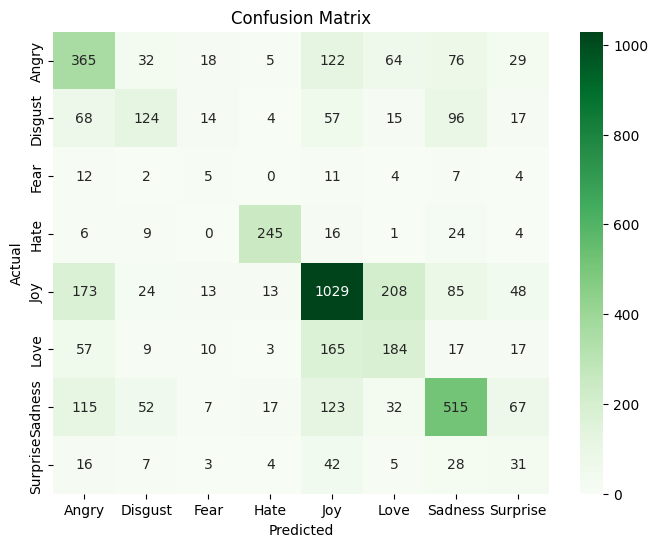

In [ ]:
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 5s 20ms/step


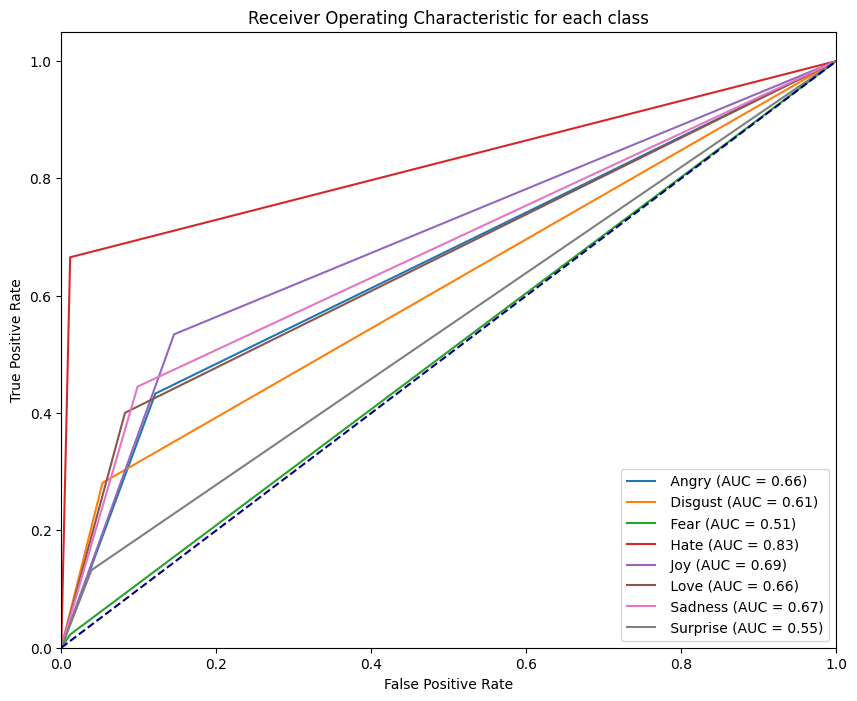

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

143/143 [==============================] - 4s 31ms/step


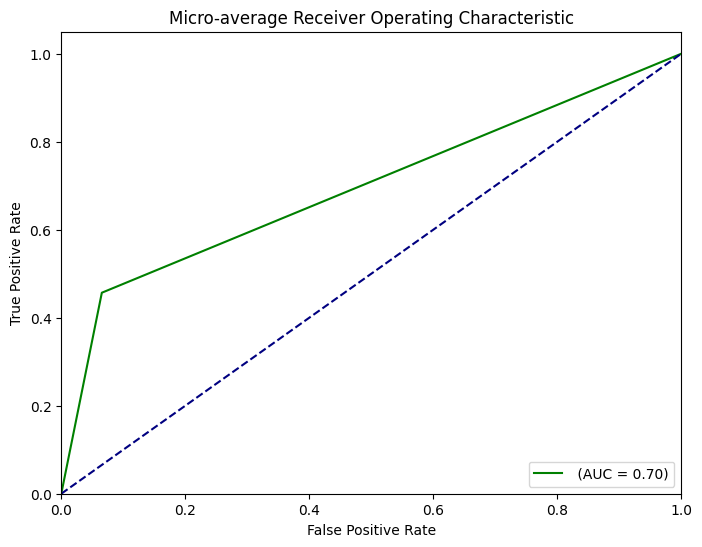

AUC =  0.6957064793130366


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))

###**BiLSTM 88 With L2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2  # Correct import

# Define parameters
embedding_dim = 128

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))  # Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))))  # Bidirectional LSTM layer with L2 regularization
model.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2_withoutOversampling.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 5303304 (20.23 MB)
Trainable params: 5303304 (20.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
285/286 [============================>.] - ETA: 0s - loss: 2.4897 - accuracy: 0.4110
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2_withoutOversampling.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 35s 100ms/step - loss: 2.4867 - accuracy: 0.4111 - val_loss: 1.4032 - val_accuracy: 0.4800
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 1.2818 - accuracy: 0.5358
Epoch 2: val_accuracy improved from 0.48000 to 0.51585, saving model to /content/drive/MyDrive/Model/Opu/BiLSTM/best_model_new2_withoutOversampling.h5
286/286 [==============================] - 21s 72ms/step - loss: 1.2818 - accuracy: 0.5358 - val_loss: 1.3946 - val_accuracy: 0.5158
Epoch 3/50
286/286 [==============================] - ETA: 0s - loss: 1.0803 - accuracy: 0.6118
Epoch 3: val_accuracy did not improve from 0.51585
286/286 [==============================] - 14s 49ms/step - loss: 1.0803 - accuracy: 0.6118 - val_loss: 1.3985 - val_accuracy: 0.5137
Epoch 4/50
285/286 [============================>.] - ETA: 0s - loss: 0.9596 - accuracy: 0.6602
Epoch 4: val_accuracy did not improve from 0.51585
286/286 [==============================] - 16s 55ms/step - 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


143/143 [==============================] - 4s 17ms/step
Accuracy: 0.4783
Precision: 0.5109
Recall: 0.4783
F1-Score: 0.4913


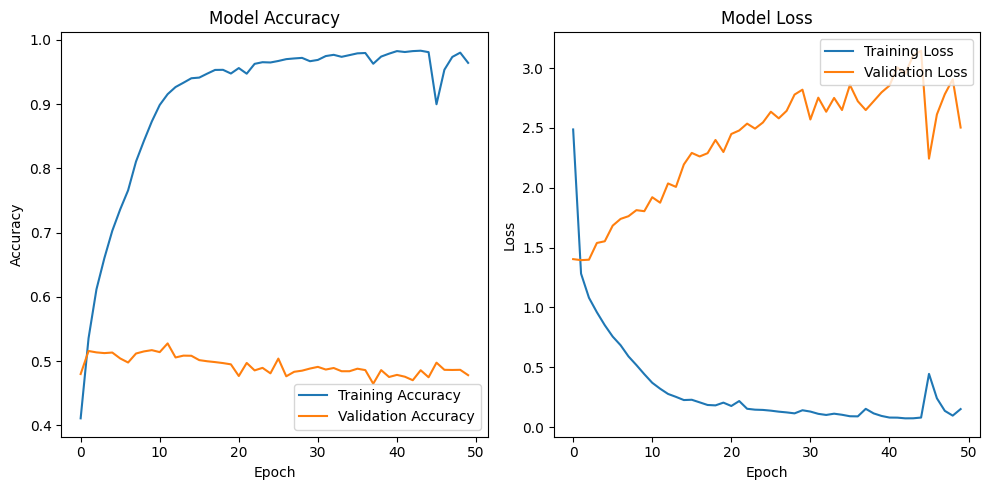

Classification Report:
              precision    recall  f1-score   support

       Angry       0.38      0.46      0.42       711
     Disgust       0.31      0.31      0.31       395
        Fear       0.01      0.02      0.02        45
        Hate       0.80      0.67      0.73       305
         Joy       0.65      0.56      0.60      1593
        Love       0.35      0.41      0.38       462
     Sadness       0.53      0.46      0.49       928
    Surprise       0.08      0.15      0.11       136

    accuracy                           0.48      4575
   macro avg       0.39      0.38      0.38      4575
weighted avg       0.51      0.48      0.49      4575



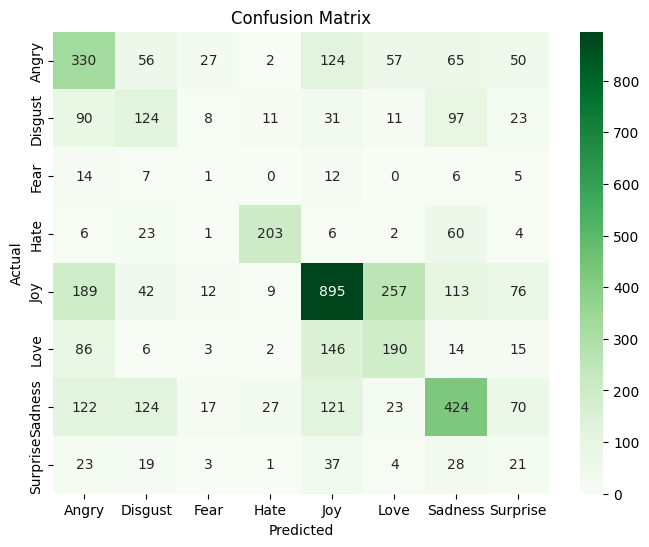

In [ ]:
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 5s 20ms/step


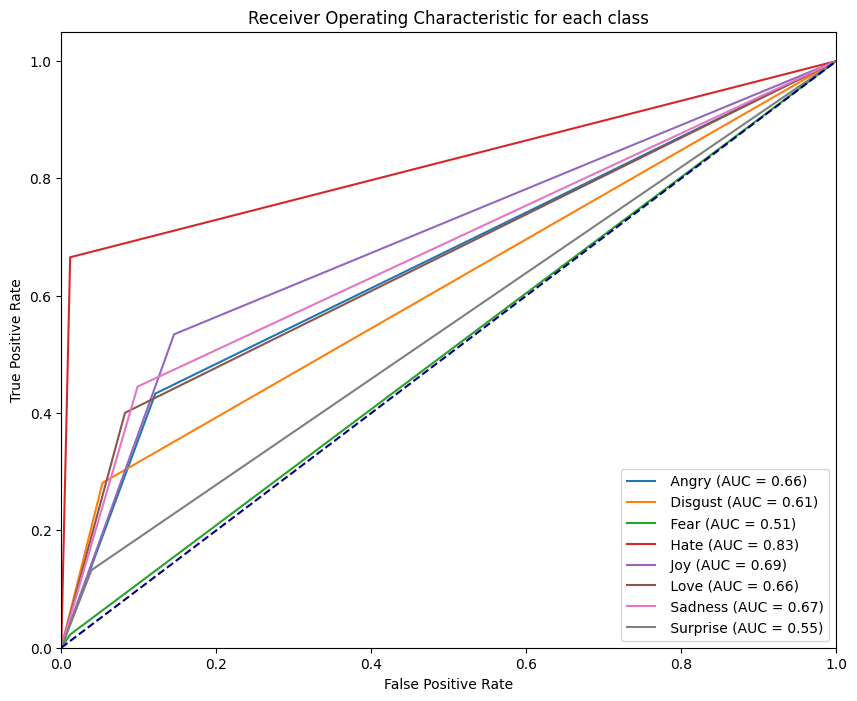

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

143/143 [==============================] - 4s 31ms/step


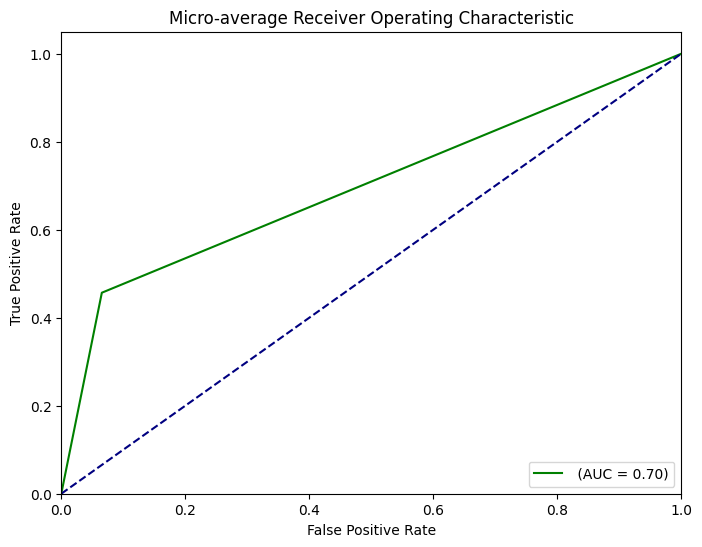

AUC =  0.6957064793130366


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))

In [ ]:
model.save('/content/drive/MyDrive/Model/Opu/BiLSTM/best_model_BiLstm_withoutOversampling(47_acc).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Lstm

### **LSTM 52**

In [ ]:
from keras.layers import Layer, LSTM, Dense, Embedding, Input
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))


checkpoint = ModelCheckpoint('/content/drive/MyDrive/opu/LSTM/best_model_lstm', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 lstm_4 (LSTM)               (None, 250, 64)           49408     
                                                                 
 flatten_4 (Flatten)         (None, 16000)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 128008    
                                                                 
Total params: 5282056 (20.15 MB)
Trainable params: 5282056 (20.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 1.7844 - accuracy: 0.3309
Epoch 1: val_accuracy improved from -inf to 0.34820, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm
286/286 [==============================] - 69s 221ms/step - loss: 1.7844 - accuracy: 0.3309 - val_loss: 1.7197 - val_accuracy: 0.3482
Epoch 2/50
283/286 [============================>.] - ETA: 0s - loss: 1.7014 - accuracy: 0.3556
Epoch 2: val_accuracy improved from 0.34820 to 0.38667, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm
286/286 [==============================] - 17s 60ms/step - loss: 1.7009 - accuracy: 0.3562 - val_loss: 1.6218 - val_accuracy: 0.3867
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 1.5256 - accuracy: 0.4348
Epoch 3: val_accuracy improved from 0.38667 to 0.47344, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm
286/286 [==============================] - 22s 77ms/step - loss: 1.5252 - accuracy: 0.43

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


143/143 [==============================] - 4s 15ms/step
Accuracy: 0.5259
Precision: 0.4659
Recall: 0.5259
F1-Score: 0.4763


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


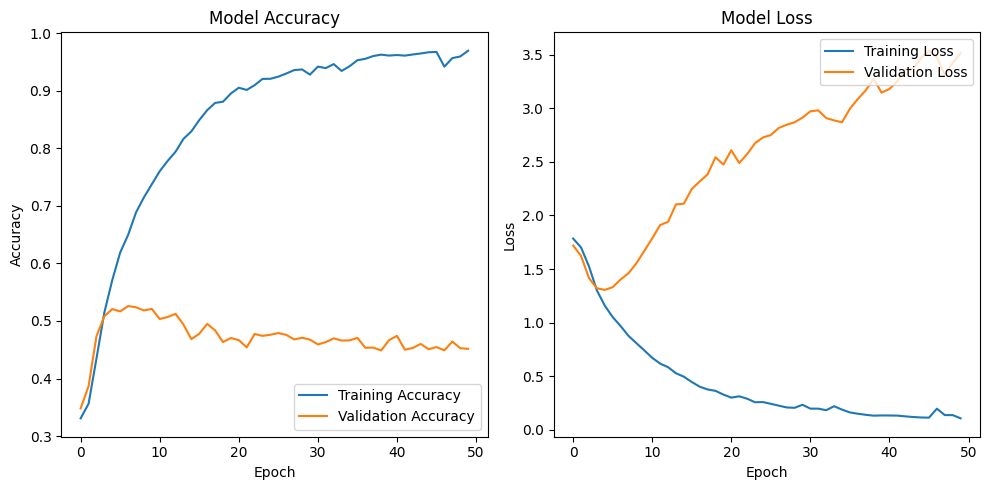

Classification Report:
              precision    recall  f1-score   support

       Angry       0.31      0.46      0.37       711
     Disgust       0.58      0.15      0.24       395
        Fear       0.00      0.00      0.00        45
        Hate       0.85      0.67      0.74       305
         Joy       0.61      0.83      0.71      1593
        Love       0.00      0.00      0.00       462
     Sadness       0.48      0.53      0.51       928
    Surprise       0.00      0.00      0.00       136

    accuracy                           0.53      4575
   macro avg       0.35      0.33      0.32      4575
weighted avg       0.47      0.53      0.48      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


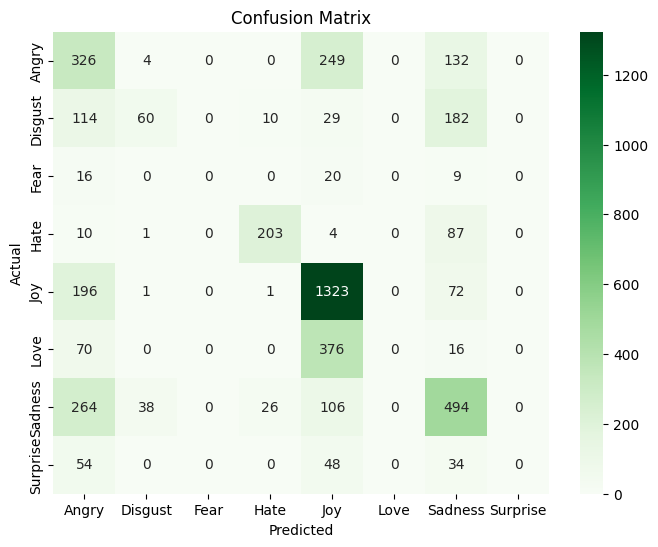

In [ ]:
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 2s 10ms/step


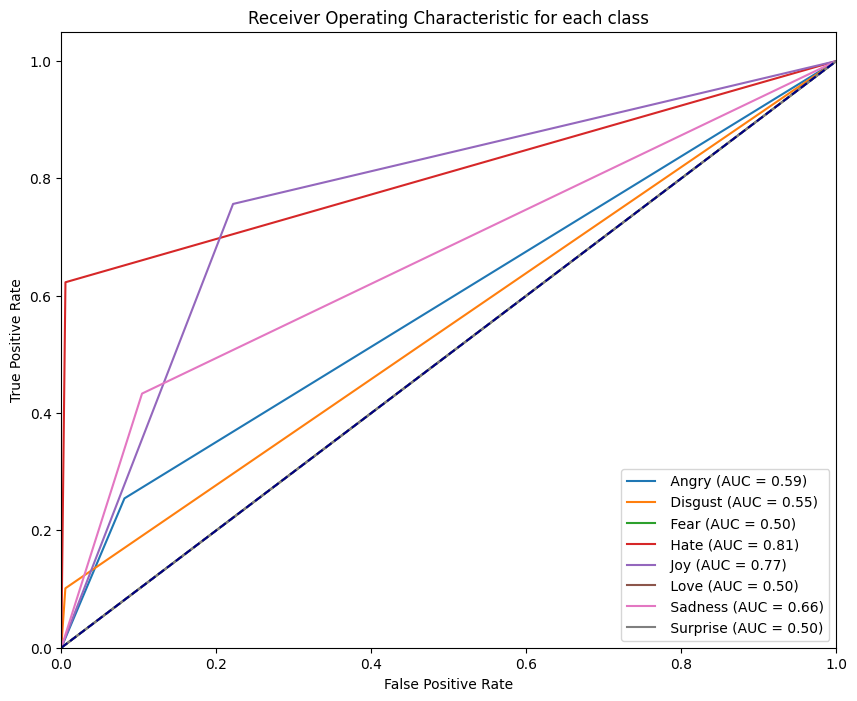

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 2s 11ms/step


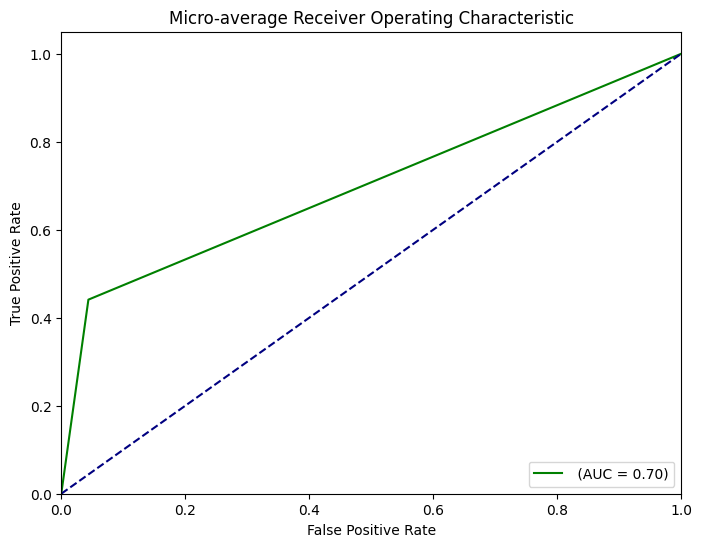

AUC =  0.6986729117876659


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


###**LSTM 52 with L2**

In [ ]:
from keras.layers import Layer, LSTM, Dense, Embedding, Input
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))


checkpoint = ModelCheckpoint('/content/drive/MyDrive/opu/LSTM/best_model_lstm2', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 lstm_3 (LSTM)               (None, 250, 64)           49408     
                                                                 
 flatten_3 (Flatten)         (None, 16000)             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 128008    
                                                                 
Total params: 5282056 (20.15 MB)
Trainable params: 5282056 (20.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 1.7747 - accuracy: 0.3293
Epoch 1: val_accuracy improved from -inf to 0.36044, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm2
286/286 [==============================] - 59s 186ms/step - loss: 1.7747 - accuracy: 0.3293 - val_loss: 1.7065 - val_accuracy: 0.3604
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 1.6657 - accuracy: 0.3739
Epoch 2: val_accuracy improved from 0.36044 to 0.41749, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm2
286/286 [==============================] - 12s 41ms/step - loss: 1.6657 - accuracy: 0.3739 - val_loss: 1.5569 - val_accuracy: 0.4175
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 1.4418 - accuracy: 0.4634
Epoch 3: val_accuracy improved from 0.41749 to 0.48481, saving model to /content/drive/MyDrive/opu/LSTM/best_model_lstm2
286/286 [==============================] - 12s 41ms/step - loss: 1.4420 - accuracy: 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


143/143 [==============================] - 1s 5ms/step
Accuracy: 0.5259
Precision: 0.4605
Recall: 0.5259
F1-Score: 0.4849


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


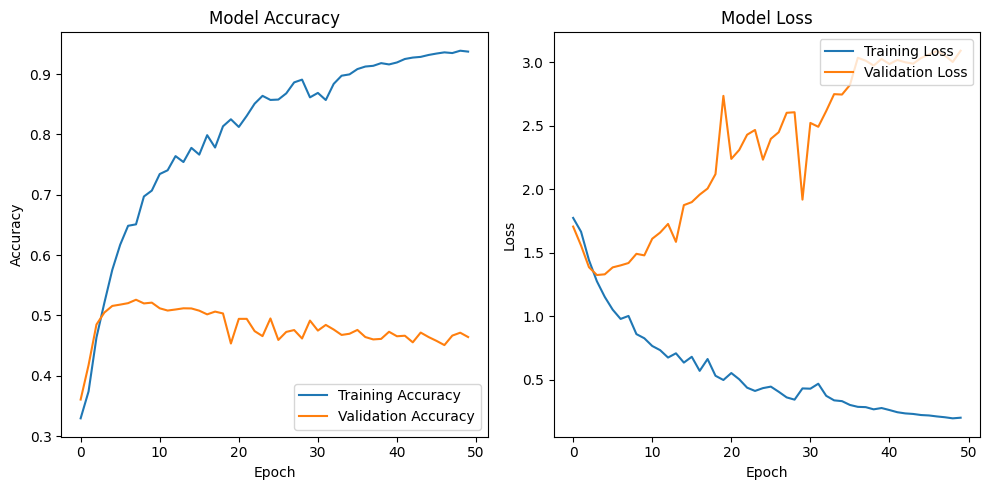

Classification Report:
              precision    recall  f1-score   support

       Angry       0.31      0.46      0.37       711
     Disgust       0.51      0.29      0.37       395
        Fear       0.00      0.00      0.00        45
        Hate       0.73      0.71      0.72       305
         Joy       0.63      0.78      0.70      1593
        Love       0.00      0.00      0.00       462
     Sadness       0.50      0.54      0.52       928
    Surprise       0.00      0.00      0.00       136

    accuracy                           0.53      4575
   macro avg       0.33      0.35      0.33      4575
weighted avg       0.46      0.53      0.48      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


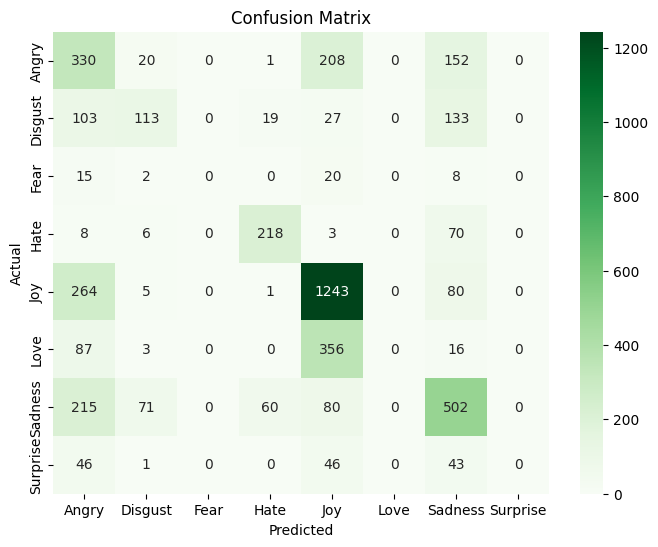

In [ ]:
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 1s 6ms/step


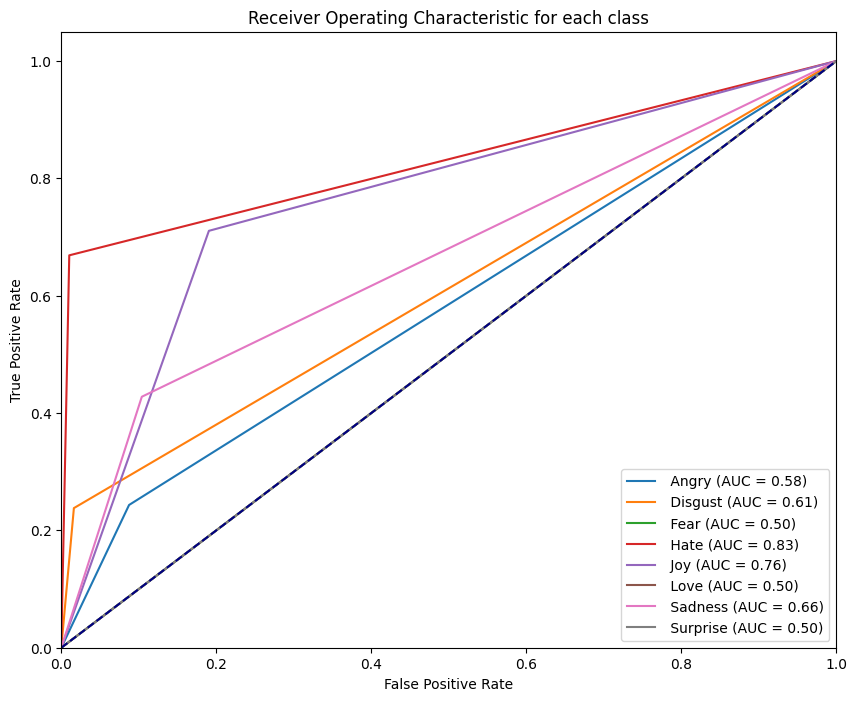

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 1s 6ms/step


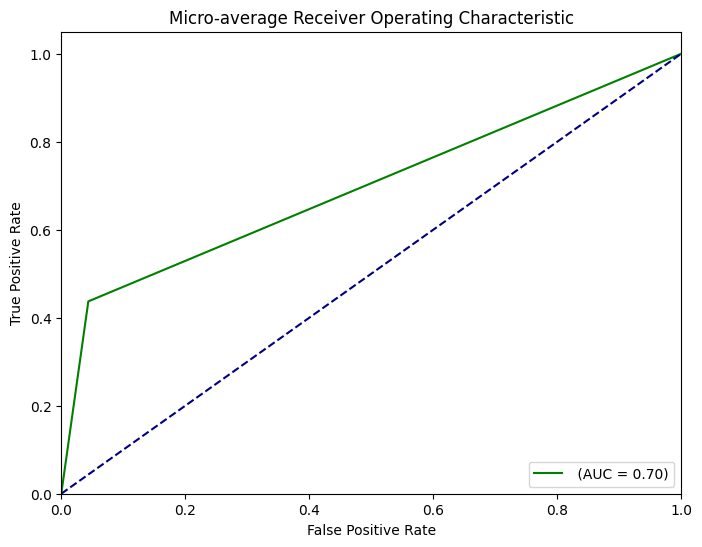

AUC =  0.696768149882904


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


## **CNN+LSTM**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Concatenate, concatenate
from keras.callbacks import ModelCheckpoint
embedding_dim = 128

input_shape = (max_sequence_length,)

cnn_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(cnn_input)
conv1 = Conv1D(128, 5, activation='relu')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten1 = Flatten()(pool1)

lstm_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(lstm_input)
lstm = LSTM(128)(embedding_layer)

merged = concatenate([flatten1, lstm])

dense_layer = Dense(128, activation='relu')(merged)
output = Dense(8, activation='softmax')(dense_layer)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 250, 128)             5104640   ['input_5[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 248, 64)              24640     ['embedding_3[0][0]']         
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 124, 64)              0         ['conv1d_3[0][0]']            
 g1D)                                                                                       

In [ ]:
history = model.fit([X_train,X_train], y_train, epochs=50, batch_size=64, validation_data=([X_test,X_test], y_test), callbacks=[checkpoint])

Epoch 1/50
285/286 [============================>.] - ETA: 0s - loss: 1.7767 - accuracy: 0.3269
Epoch 1: val_accuracy improved from -inf to 0.35366, saving model to /content/drive/MyDrive/opu/HBmodel/best_model
286/286 [==============================] - 53s 163ms/step - loss: 1.7768 - accuracy: 0.3268 - val_loss: 1.7153 - val_accuracy: 0.3537
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 1.6998 - accuracy: 0.3558
Epoch 2: val_accuracy improved from 0.35366 to 0.38339, saving model to /content/drive/MyDrive/opu/HBmodel/best_model
286/286 [==============================] - 23s 81ms/step - loss: 1.6998 - accuracy: 0.3558 - val_loss: 1.6441 - val_accuracy: 0.3834
Epoch 3/50
284/286 [============================>.] - ETA: 0s - loss: 1.5212 - accuracy: 0.4347
Epoch 3: val_accuracy improved from 0.38339 to 0.47978, saving model to /content/drive/MyDrive/opu/HBmodel/best_model
286/286 [==============================] - 16s 56ms/step - loss: 1.5204 - accuracy: 0.4354 - v

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
model = load_model('/content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5')
def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict([X_test,X_test])
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


143/143 [==============================] - 1s 6ms/step
Accuracy: 0.5386
Precision: 0.5125
Recall: 0.5386
F1-Score: 0.5129


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


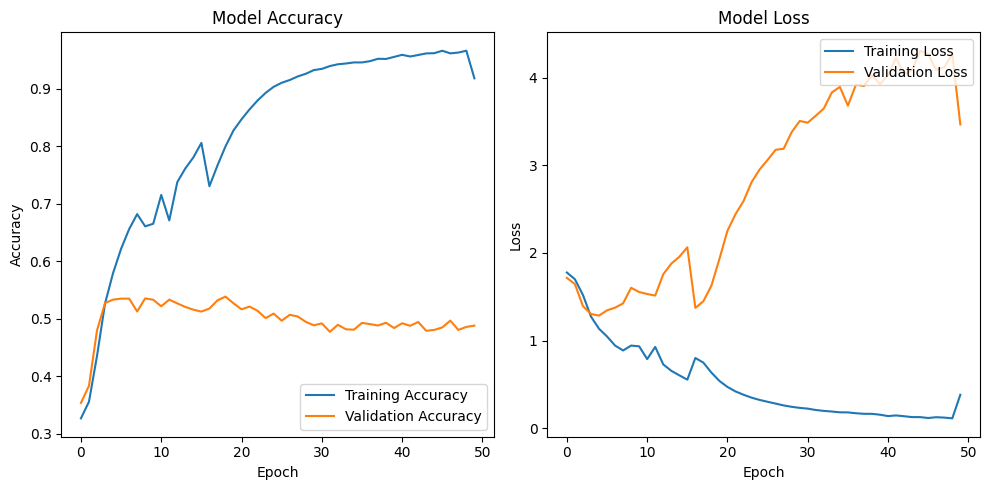

Classification Report:
              precision    recall  f1-score   support

       Angry       0.37      0.35      0.36       711
     Disgust       0.47      0.26      0.34       395
        Fear       0.00      0.00      0.00        45
        Hate       0.88      0.72      0.79       305
         Joy       0.66      0.77      0.71      1593
        Love       0.32      0.14      0.19       462
     Sadness       0.45      0.64      0.53       928
    Surprise       0.09      0.02      0.04       136

    accuracy                           0.54      4575
   macro avg       0.41      0.36      0.37      4575
weighted avg       0.51      0.54      0.51      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


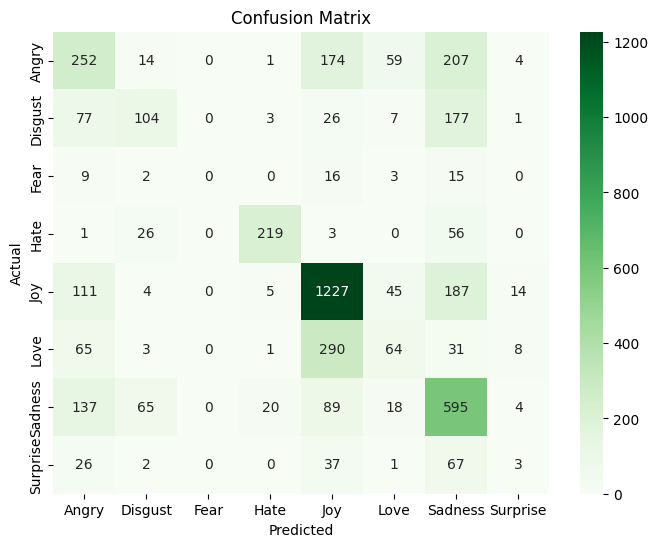

In [ ]:
evaluate_model(model, X_test, y_test, history)

143/143 [==============================] - 2s 12ms/step


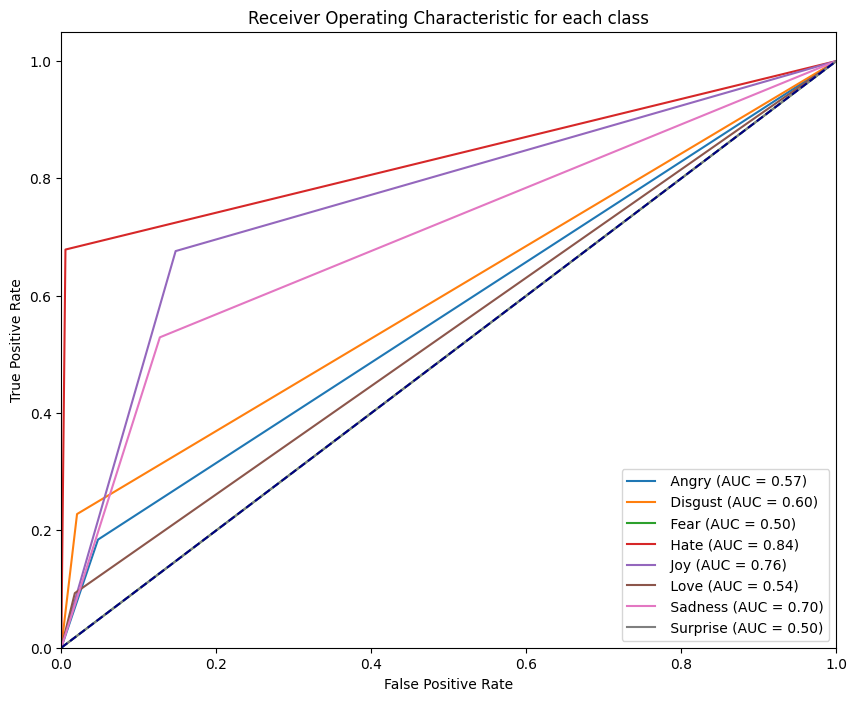

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict([X_test,X_test])
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


143/143 [==============================] - 2s 13ms/step


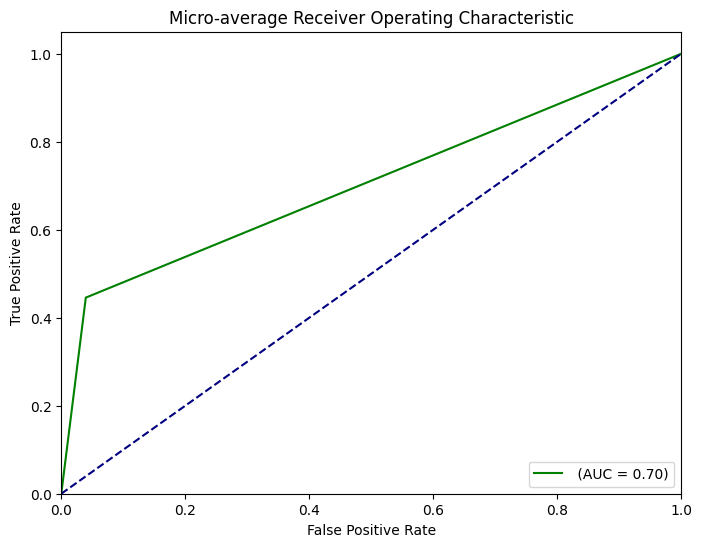

AUC =  0.7030601092896175


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))
